# Model Distillation & Filter Pruning in the CIFAR10 Dataset

---

In this notebook, we train a state-of-the-art CNN conisting of 6 convolutional layers prior to the fully-connected part on the CIFAR10 dataset. We distillate this deep neural network (teacher model) into three different shallow student networks: one consisting of only one fully-connected layer, one with one convolutional layer prior to the fully-connected part and one with two convolutional layers prior to the fully-connected part. The distillation method used is "Matching the Logits" as it is described by Ba & Caruana on [Do Deep Nets Really Need to be Deep?](https://arxiv.org/pdf/1312.6184.pdf). Later on, we distillate the teacher model into a shallow network of two convolutional layers prior to the fully-connected part using another technique called "Ranging the Teacher’s Temperature" as it is described by Hinton, Vinyals & Dean on [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531.pdf). Finally, the student model with the best accuracy in the test set is filter pruned using [PRUNING FILTERS FOR EFFICIENT CONVNETS](https://arxiv.org/pdf/1608.08710.pdf) by Li, Kadav, Durdanovic, Samet & Graf.

## Load the Neccesary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15.0

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K
from keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from scipy.io import loadmat
from keras.datasets import cifar10

## Define The Model Architectures

### CNN Network 

In [3]:
def get_CNN_model():
  #CNN network for classification
  cifar_model = models.Sequential(name='CNN')
  cifar_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  cifar_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  cifar_model.add(layers.MaxPooling2D((2, 2)))
  cifar_model.add(Dropout(0.2))
  cifar_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  cifar_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  cifar_model.add(layers.MaxPooling2D((2, 2)))
  cifar_model.add(Dropout(0.3))
  cifar_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  cifar_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  cifar_model.add(layers.MaxPooling2D((2, 2)))
  cifar_model.add(Dropout(0.4))
  cifar_model.add(Flatten())
  cifar_model.add(Dense(128, activation='relu'))
  cifar_model.add(Dropout(0.5))
  cifar_model.add(Dense(10, name="logit"))
  cifar_model.add(layers.Activation('softmax'))
  return cifar_model

### Shallow Network (SNN)

In [4]:
def get_SNN_model(hidden_layers, name):
  #SNN network for classification
  cifar_model = models.Sequential(name=name)
  cifar_model.add(layers.Dense(hidden_layers, activation='relu', input_shape=(32 * 32 * 3,)))
  cifar_model.add(layers.Dense(10,name="logit"))
  cifar_model.add(layers.Activation('softmax'))
  return cifar_model

### Shallow CNN Network (S-CNN) with 1 Convolutional Layer

In [5]:
def get_SCNN_model_layer1(channels):
  #SCNN network for classification
  cifar_model = models.Sequential(name='SCNN')
  cifar_model.add(layers.Conv2D(channels,(3,3),activation='relu', input_shape=(32, 32, 3)))
  cifar_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  cifar_model.add(Flatten())
  cifar_model.add(layers.Dense(128, activation='relu'))
  cifar_model.add(layers.Dense(10,name="logit"))
  cifar_model.add(layers.Activation('softmax'))
  return cifar_model

### Shallow CNN Network (S-CNN) with 2 Convolutional Layers

In [6]:
def get_SCNN_model_layer2(channels_l1, channels_l2):
  #SCNN network for classification
  cifar_model = models.Sequential(name='SCNN')
  cifar_model.add(layers.Conv2D(channels_l1,(3,3),activation='relu', input_shape=(32, 32, 3)))
  cifar_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  cifar_model.add(layers.Conv2D(channels_l2,(3,3),activation='relu'))
  cifar_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  cifar_model.add(Flatten())
  cifar_model.add(layers.Dense(128, activation='relu'))
  cifar_model.add(layers.Dense(10,name="logit"))
  cifar_model.add(layers.Activation('softmax'))
  return cifar_model

## Load Dataset and Preprocessing

In [ ]:
# CIFAR-10
(x_train, y_train), (x_acc_test, y_acc_test) = cifar10.load_data()

#Split between Training and Validation datasets (x_train = train & x_test = validation)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state = 100)

# Create labels and one-hot-encoding
y_labels_train = y_train
y_labels_test = y_test
y_labels_acc_test = y_acc_test
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_acc_test = keras.utils.to_categorical(y_acc_test, 10)

In [ ]:
#Preprocess data for CNN
x_train_cnn = x_train.reshape(-1, 32, 32, 3)
x_train_cnn = x_train_cnn.astype('float32')
x_train_cnn /= 255.

x_test_cnn = x_test.reshape(-1, 32, 32, 3)
x_test_cnn = x_test_cnn.astype('float32')
x_test_cnn /= 255.

x_acc_test_cnn = x_acc_test.reshape(-1, 32, 32, 3)
x_acc_test_cnn = x_acc_test_cnn.astype('float32')
x_acc_test_cnn /= 255.

In [ ]:
#Preprocess data for SNN
x_train_snn = x_train.reshape((40000, 32 * 32 * 3))
x_train_snn  = x_train_snn.astype('float32') / 255

x_acc_test_snn  = x_acc_test.reshape((10000, 32 * 32 * 3))
x_acc_test_snn  = x_acc_test_snn.astype('float32') / 255

x_test_snn  = x_test.reshape((10000, 32 * 32 * 3))
x_test_snn  = x_test_snn.astype('float32') / 255

In [ ]:
# Save the data 
np.save('x_train_snn', x_train_snn)
np.save('x_acc_test_snn', x_acc_test_snn)
np.save('x_test_snn', x_test_snn)
np.save('x_train_cnn', x_train_cnn)
np.save('x_acc_test_cnn', x_acc_test_cnn)
np.save('x_test_cnn', x_test_cnn)

In [14]:
# Restore the data
x_train_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_snn.npy')
x_acc_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_snn.npy')
x_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_snn.npy')
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

In [ ]:
# Save the labels
np.save('y_labels_train', y_labels_train)
np.save('y_labels_test', y_labels_test)
np.save('y_labels_acc_test', y_labels_acc_test)
np.save('y_train', y_train)
np.save('y_test', y_test)
np.save('y_acc_test', y_acc_test)

In [15]:
# Restore the labels
y_labels_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_train.npy')
y_labels_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_test.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')
y_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_train.npy')
y_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_test.npy')
y_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_acc_test.npy')

In [ ]:
# Store the CIFAR-100 dataset and combine it with CIFAR-10 as extra dataset for the experiments
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')

cifar10_100_cnn_train_extra = x_train.reshape(-1, 32, 32, 3)
cifar10_100_cnn_train_extra = cifar10_100_cnn_train_extra.astype('float32')
cifar10_100_cnn_train_extra /= 255.

cifar10_100_cnn_test_extra = x_test.reshape(-1, 32, 32, 3)
cifar10_100_cnn_test_extra = cifar10_100_cnn_test_extra.astype('float32')
cifar10_100_cnn_test_extra /= 255.

cifar10_100_snn_train_extra  = x_train.reshape((50000, 32 * 32 * 3))
cifar10_100_snn_train_extra  = cifar10_100_snn_train_extra.astype('float32') / 255

cifar10_100_snn_test_extra  = x_test.reshape((10000, 32 * 32 * 3))
cifar10_100_snn_test_extra  = cifar10_100_snn_test_extra.astype('float32') / 255

# Restore the data
x_train_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_snn.npy')
x_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_snn.npy')
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

x_train_cnn_extra_cifar = np.concatenate((x_train_cnn, cifar10_100_cnn_train_extra), axis=0)
x_test_cnn_extra_cifar = np.concatenate((x_test_cnn, cifar10_100_cnn_test_extra), axis=0)
x_train_snn_extra_cifar = np.concatenate((x_train_snn, cifar10_100_snn_train_extra), axis=0)
x_test_snn_extra_cifar = np.concatenate((x_test_snn, cifar10_100_snn_test_extra), axis=0)

np.save('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn_extra_cifar', x_train_cnn_extra_cifar)
np.save('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn_extra_cifar', x_test_cnn_extra_cifar)
np.save('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_snn_extra_cifar', x_train_snn_extra_cifar)
np.save('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_snn_extra_cifar', x_test_snn_extra_cifar)

## Training 

### CNN

In [ ]:
#Train CNN
def train_cnn(cifar_model,x_train, y_train,x_test, y_test):
  earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  cifar_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return cifar_model

In [ ]:
cifar_model = get_CNN_model()
cifar_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
cifar_model.summary()

In [ ]:
cifar_model = train_cnn(cifar_model, x_train_cnn, y_train, x_test_cnn, y_test)
cifar_model.save('CNN_CIFAR.h5')
print ('Model Saved')

### SNN

In [ ]:
#Train SNN
def train_snn(cifar_model, x_train, y_train ,x_test, y_test, metric):
  earlyStop = EarlyStopping(monitor=metric, min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  cifar_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=0, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return cifar_model

In [ ]:
cifar_model = get_SNN_model(hidden_layers=180, name='SNN')
cifar_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cifar_model.summary()

In [ ]:
#Save trained SNN model
cifar_model = train_snn(cifar_model,x_train_snn, y_train, x_test_snn, y_test, 'val_accuracy')
cifar_model.save('SNN_CIFAR10.h5')
print ('Model Saved')

### SCNN

In [ ]:
#Train SCNN
def train_scnn(cifar_model,x_train, y_train,x_test, y_test):
  earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  cifar_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=0, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return cifar_model

In [ ]:
cifar_model = get_SCNN_model_layer1(channels=16)
cifar_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cifar_model.summary()

In [ ]:
svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=128)
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
svhn_model.summary()

In [ ]:
#Save trained SCNN model
cifar_model = train_scnn(cifar_model, x_train_cnn, y_train, x_test_cnn, y_test)
cifar_model.save('SCNN_CIFAR.h5')
print ('Model Saved')

### Learning Curves

In [ ]:
loss_train_cnn =[1.9016067039489746, 1.493368989944458, 1.284794349861145, 1.1446422939300538, 1.0352944845199585, 0.9637775631904602, 0.9017991508483887, 0.8556458246231079, 0.8088563574790955, 0.7795551616668701, 0.7326367043495178, 0.7089165151119232, 0.6796124543190002, 0.6549131265640259, 0.6447658416748047, 0.6275906898498536, 0.6074599155902862, 0.5979357412338256, 0.577306444644928, 0.5717351808547974, 0.5557767436027526, 0.5481189541816711, 0.5387865597724915, 0.5283629526138306, 0.5111766700744629, 0.5057262913703918, 0.49809154381752013, 0.49376131496429443, 0.4879552734851837, 0.48016737775802615, 0.47468429985046384, 0.4695361728668213, 0.46509699363708495, 0.4543753202438354, 0.45343369312286375, 0.4423770314216614, 0.4406249185562134, 0.43703458380699156, 0.4378488241195679, 0.42785513529777525, 0.42033344354629515, 0.4154775609493256, 0.41719441571235655, 0.41083251724243164, 0.4047753040313721, 0.4021350436210632, 0.4035261606693268, 0.39219172253608703, 0.3971164204597473, 0.39393933801651, 0.39211469583511355, 0.3880910226821899, 0.3836565311908722, 0.37607091755867006, 0.3761158265590668, 0.3716227520942688, 0.37077935395240785, 0.36569848709106445, 0.36158613748550417, 0.35939109392166135, 0.36425642161369326]
loss_test_cnn =[1.5434800075531006, 1.2386110286712646, 1.1182534027099609, 0.9504619892120362, 0.9091577365875244, 0.8004219980239868, 0.7757581886291504, 0.7692789287567139, 0.7445533398628235, 0.701153339958191, 0.6590069139480591, 0.6973875053405761, 0.6280067436218262, 0.6055245948791503, 0.6418542722702026, 0.6004766887664795, 0.6159591238021851, 0.6168704126358032, 0.6103970026016236, 0.5656379898071289, 0.5537006357192993, 0.5810683401107788, 0.5593267353057861, 0.5629502677917481, 0.5532144426345825, 0.5610933441162109, 0.5825725109100341, 0.5602187335968017, 0.5938638404846192, 0.5540757024765015, 0.5759997924804687, 0.5775434692382813, 0.56871721534729, 0.545997897529602, 0.5575204404830932, 0.559731618309021, 0.5513039978027344, 0.5626900248527527, 0.5552137800216674, 0.5493026695251465, 0.5495561939239502, 0.5543775085449218, 0.5429323976516723, 0.5616576940536498, 0.556914588356018, 0.5629978700637818, 0.5410551824569703, 0.5713771476745605, 0.5479265144348144, 0.5510257964134216, 0.5270996474266052, 0.5671704110145569, 0.5420893050193787, 0.5410247226715088, 0.5539430704116821, 0.5395973859786988, 0.5865475509643555, 0.5671368152618408, 0.5535170149803161, 0.54860709400177, 0.5853386375427246]
acc_train_cnn =[0.2897, 0.4517, 0.536025, 0.594725, 0.6335, 0.66315, 0.6851, 0.70365, 0.7182, 0.729525, 0.74705, 0.755475, 0.76495, 0.77195, 0.777275, 0.783675, 0.79035, 0.79395, 0.801525, 0.801925, 0.808475, 0.81035, 0.812675, 0.817325, 0.8213, 0.826975, 0.828375, 0.8305, 0.830425, 0.8322, 0.836625, 0.83655, 0.83965, 0.8402, 0.84325, 0.84445, 0.846725, 0.848075, 0.84835, 0.85245, 0.851925, 0.853925, 0.85475, 0.85795, 0.857675, 0.858975, 0.86075, 0.86265, 0.8624, 0.8609, 0.8623, 0.86575, 0.86675, 0.868975, 0.86835, 0.870475, 0.8686, 0.87315, 0.874575, 0.8737, 0.8734]
acc_test_cnn = [0.42649999260902405, 0.5442000031471252, 0.6021000146865845, 0.6534000039100647, 0.6739000082015991, 0.7134000062942505, 0.7257999777793884, 0.7246999740600586, 0.7409999966621399, 0.7516999840736389, 0.762499988079071, 0.7597000002861023, 0.7784000039100647, 0.7857999801635742, 0.7724000215530396, 0.7889000177383423, 0.7890999913215637, 0.7828999757766724, 0.7928000092506409, 0.804099977016449, 0.8108000159263611, 0.7983999848365784, 0.8090999722480774, 0.8061000108718872, 0.8079000115394592, 0.8123999834060669, 0.800000011920929, 0.8122000098228455, 0.8065999746322632, 0.8134999871253967, 0.8100000023841858, 0.8105999827384949, 0.8112000226974487, 0.8123000264167786, 0.8162999749183655, 0.8220000267028809, 0.8201000094413757, 0.8172000050544739, 0.8177000284194946, 0.8205999732017517, 0.8184000253677368, 0.8206999897956848, 0.8222000002861023, 0.8240000009536743, 0.8224999904632568, 0.8224999904632568, 0.8251000046730042, 0.8188999891281128, 0.8222000002861023, 0.8240000009536743, 0.8306999802589417, 0.8251000046730042, 0.8251000046730042, 0.8276000022888184, 0.8291000127792358, 0.8299999833106995, 0.819100022315979, 0.8206999897956848, 0.82669997215271, 0.8285999894142151, 0.8219000101089478]

loss_train_snn =[1.9603240032196045, 1.7828443906784057, 1.7224785116195678, 1.6667844635009765, 1.6275448932647705, 1.5963206531524659, 1.5703459075927735, 1.5361641082763673, 1.5313092300415039, 1.5088232566833497, 1.4926505172729492, 1.4852630443572998, 1.4773552368164062, 1.460033840560913, 1.4475125761032104, 1.4501289754867555, 1.4376682977676392, 1.4294484523773194, 1.425609125137329, 1.4113001361846924, 1.40661743850708, 1.4045582252502442, 1.4034966020584105, 1.3893268384933473, 1.3887500007629394, 1.382196794128418, 1.374110262489319, 1.3664626119613648, 1.3692660158157348, 1.3565531620025635, 1.3554057563781738, 1.355700806427002, 1.3464468906402587, 1.3391709117889403, 1.333127202606201, 1.3335365863800048, 1.3303657638549804, 1.3280840398788452, 1.318864873123169, 1.3093749313354492, 1.3163814235687257, 1.3124669193267822, 1.3041477588653565, 1.298173288154602, 1.2999548767089844, 1.2974907249450685, 1.2959947574615478, 1.279888526916504, 1.2838226167678832, 1.2892018171310424, 1.2897818590164185, 1.2726402183532715, 1.2708926250457764, 1.274106418800354]
loss_test_snn =[1.8313122810363769, 1.7397435819625855, 1.7223326251983642, 1.6756344161987304, 1.627164186668396, 1.6036480049133301, 1.6017494966506958, 1.5909512149810792, 1.5899704538345336, 1.6017208637237548, 1.5579538497924805, 1.5500532711029054, 1.5530563280105592, 1.5297244804382324, 1.5468486423492431, 1.6197007940292358, 1.5688127922058106, 1.5289129165649413, 1.5448485328674317, 1.5307564224243164, 1.540492726135254, 1.5011090703964234, 1.5068297273635864, 1.5093181232452393, 1.5246333290100098, 1.4881167295455933, 1.4996326122283936, 1.5012147062301635, 1.501468004798889, 1.527214030456543, 1.4880384822845458, 1.4895409507751465, 1.5018639881134033, 1.4947924055099486, 1.5113395950317383, 1.4963734680175782, 1.5074545915603639, 1.508122992706299, 1.5113469076156616, 1.5077125688552857, 1.47714258518219, 1.5241901556015014, 1.4858635530471802, 1.4963824214935302, 1.5001031684875488, 1.4932689083099364, 1.4989918296813964, 1.490331067276001, 1.498123949623108, 1.5334700340270997, 1.5328573467254638, 1.4935132373809814, 1.5070522972106934, 1.4909734233856202]
acc_train_snn =[0.3037, 0.36925, 0.390875, 0.411825, 0.422475, 0.43735, 0.44605, 0.4597, 0.457225, 0.4646, 0.4749, 0.4754, 0.474675, 0.483125, 0.4886, 0.4856, 0.493225, 0.492525, 0.495325, 0.50205, 0.502125, 0.504275, 0.5037, 0.5069, 0.509875, 0.5108, 0.5135, 0.515475, 0.5148, 0.518075, 0.519075, 0.519075, 0.521475, 0.523775, 0.52775, 0.52645, 0.527075, 0.527625, 0.533025, 0.5353, 0.5335, 0.53595, 0.537775, 0.539775, 0.53795, 0.542025, 0.541825, 0.5472, 0.543775, 0.54095, 0.54145, 0.546975, 0.550025, 0.548575]
acc_test_snn =[0.3375999927520752, 0.38609999418258667, 0.3937000036239624, 0.4099999964237213, 0.42170000076293945, 0.43149998784065247, 0.42910000681877136, 0.4320000112056732, 0.4336000084877014, 0.4325000047683716, 0.4530999958515167, 0.4542999863624573, 0.4489000141620636, 0.4629000127315521, 0.4462999999523163, 0.4399000108242035, 0.44350001215934753, 0.4659999907016754, 0.4487999975681305, 0.4641000032424927, 0.4553000032901764, 0.46860000491142273, 0.4674000144004822, 0.4675000011920929, 0.4674000144004822, 0.47279998660087585, 0.4749999940395355, 0.4650000035762787, 0.4690000116825104, 0.4659999907016754, 0.47850000858306885, 0.4738999903202057, 0.4666000008583069, 0.47540000081062317, 0.4731999933719635, 0.47530001401901245, 0.4729999899864197, 0.46970000863075256, 0.4684999883174896, 0.47049999237060547, 0.4878999888896942, 0.47450000047683716, 0.48010000586509705, 0.4884999990463257, 0.47760000824928284, 0.4781999886035919, 0.4796999990940094, 0.48100000619888306, 0.4771000146865845, 0.4648999869823456, 0.4706999957561493, 0.478300005197525, 0.4805000126361847, 0.474700003862381]

loss_train_scnn1 =[1.6038212553024291, 1.297599090194702, 1.183296042060852, 1.112826995563507, 1.0527451741218568, 1.0024031805038451, 0.9636852094650269, 0.9194976403236389, 0.877105917930603, 0.8393199112892151, 0.7915143722534179, 0.7560849585533143, 0.721845214176178, 0.6875692688941956, 0.651014478969574, 0.6163051651954651, 0.5853703899383544, 0.5480481018066407, 0.5209253153800965, 0.48767771310806274, 0.4545512957572937, 0.4287860595703125, 0.3955270004272461, 0.3734948909759521, 0.3463851847648621, 0.31983073172569276, 0.2955147518157959, 0.27304861397743224, 0.24938670105934144]
loss_test_scnn1= [1.4018450675964356, 1.2462404808044434, 1.197455646133423, 1.1524615558624267, 1.1310507442474365, 1.0995633113861083, 1.0954222301483154, 1.0601170925140382, 1.0666297855377198, 1.0620021278381349, 1.0640691734313965, 1.0593602897644043, 1.0779108224868774, 1.0725404256820679, 1.0878550649642944, 1.1077063840866088, 1.109410512161255, 1.132105340194702, 1.1419096950531007, 1.156861125564575, 1.2040555179595946, 1.261141686630249, 1.27758292388916, 1.3002053651809693, 1.3210583253860473, 1.3696956823348998, 1.3785356859207154, 1.4522796684265136, 1.4785912117004394]
acc_train_scnn1 =[0.4338, 0.547775, 0.5876, 0.6134, 0.634725, 0.653875, 0.6649, 0.681925, 0.697525, 0.712175, 0.725625, 0.738175, 0.751675, 0.76715, 0.77575, 0.788425, 0.799325, 0.81385, 0.824175, 0.83765, 0.8505, 0.85935, 0.870875, 0.87925, 0.888975, 0.900225, 0.907825, 0.9156, 0.9256]
acc_test_scnn1 =[0.5062000155448914, 0.559499979019165, 0.574999988079071, 0.5947999954223633, 0.6043999791145325, 0.6144000291824341, 0.6202999949455261, 0.6263999938964844, 0.6277999877929688, 0.6366000175476074, 0.6313999891281128, 0.6399000287055969, 0.6319000124931335, 0.6395999789237976, 0.6383000016212463, 0.6383000016212463, 0.6385999917984009, 0.63919997215271, 0.6427000164985657, 0.6370999813079834, 0.6385999917984009, 0.6327999830245972, 0.6358000040054321, 0.6344000101089478, 0.6287000179290771, 0.6269999742507935, 0.630299985408783, 0.6241999864578247, 0.628600001335144]

loss_train_scnn2 =[1.7562161890029908, 1.42038892288208, 1.3007722902297973, 1.2211307264328002, 1.1657058801651001, 1.122064678955078, 1.0782130076408387, 1.0418228887557983, 1.0084892503738403, 0.9801023565292358, 0.9522099542617798, 0.922416806602478, 0.9044218769073487, 0.8654577994346618, 0.8412065505981445, 0.8151077175140381, 0.7840162408828736, 0.7650189657211304, 0.7438992725372314, 0.7233974653244019, 0.6976013447761535, 0.6795652769088745, 0.6611098572731018, 0.6409556560516357, 0.6239579012870788, 0.6022889164924622, 0.5867493995666504, 0.56837752161026, 0.5525751925468445, 0.5359783850193024, 0.5151112698554993, 0.5055271048545837, 0.48541623077392576, 0.4706700526237488, 0.4539559832572937, 0.4394756638050079, 0.4283503803730011]
loss_test_scnn2=[1.509856392288208, 1.3534655128479003, 1.2901609363555908, 1.21637257938385, 1.1926626487731933, 1.1851008392333984, 1.1370179161071778, 1.1145787380218506, 1.1073845973968506, 1.0945704036712647, 1.096340300178528, 1.0641189418792725, 1.0810052711486817, 1.108223530960083, 1.0952817922592164, 1.0689218147277832, 1.0647049491882323, 1.0582616258621216, 1.0682978565216064, 1.110138460922241, 1.1122930171966552, 1.1145221393585205, 1.1143887170791626, 1.1494693054199219, 1.1149367420196534, 1.1398651554107666, 1.153001491546631, 1.1887244773864747, 1.2002582550048828, 1.1905002185821534, 1.2235793182373047, 1.210555986213684, 1.2566472400665283, 1.305103117752075, 1.3046205810546876, 1.334637335395813, 1.3561111251831055]
acc_train_scnn2 =[0.3759, 0.498475, 0.542575, 0.573525, 0.591, 0.6082, 0.62545, 0.637325, 0.646825, 0.65925, 0.669725, 0.680325, 0.68625, 0.698675, 0.70985, 0.716025, 0.727825, 0.733425, 0.74385, 0.748575, 0.7598, 0.76605, 0.77465, 0.778075, 0.785175, 0.79305, 0.7997, 0.807375, 0.81155, 0.817725, 0.824075, 0.830375, 0.83555, 0.839475, 0.8475, 0.853, 0.85835]
acc_test_scnn2 =[0.45680001378059387, 0.5224999785423279, 0.5454999804496765, 0.5742999911308289, 0.5845000147819519, 0.5759000182151794, 0.597599983215332, 0.6097999811172485, 0.61080002784729, 0.6136999726295471, 0.6139000058174133, 0.6276000142097473, 0.6177999973297119, 0.6105999946594238, 0.6194000244140625, 0.6330000162124634, 0.6322000026702881, 0.6342999935150146, 0.6334999799728394, 0.6281999945640564, 0.6258999705314636, 0.6295999884605408, 0.6290000081062317, 0.6233999729156494, 0.6330000162124634, 0.6320000290870667, 0.6362000107765198, 0.6255000233650208, 0.6230999827384949, 0.6280999779701233, 0.621399998664856, 0.6241000294685364, 0.6266999840736389, 0.6241999864578247, 0.6195999979972839, 0.6227999925613403, 0.6190999746322632]


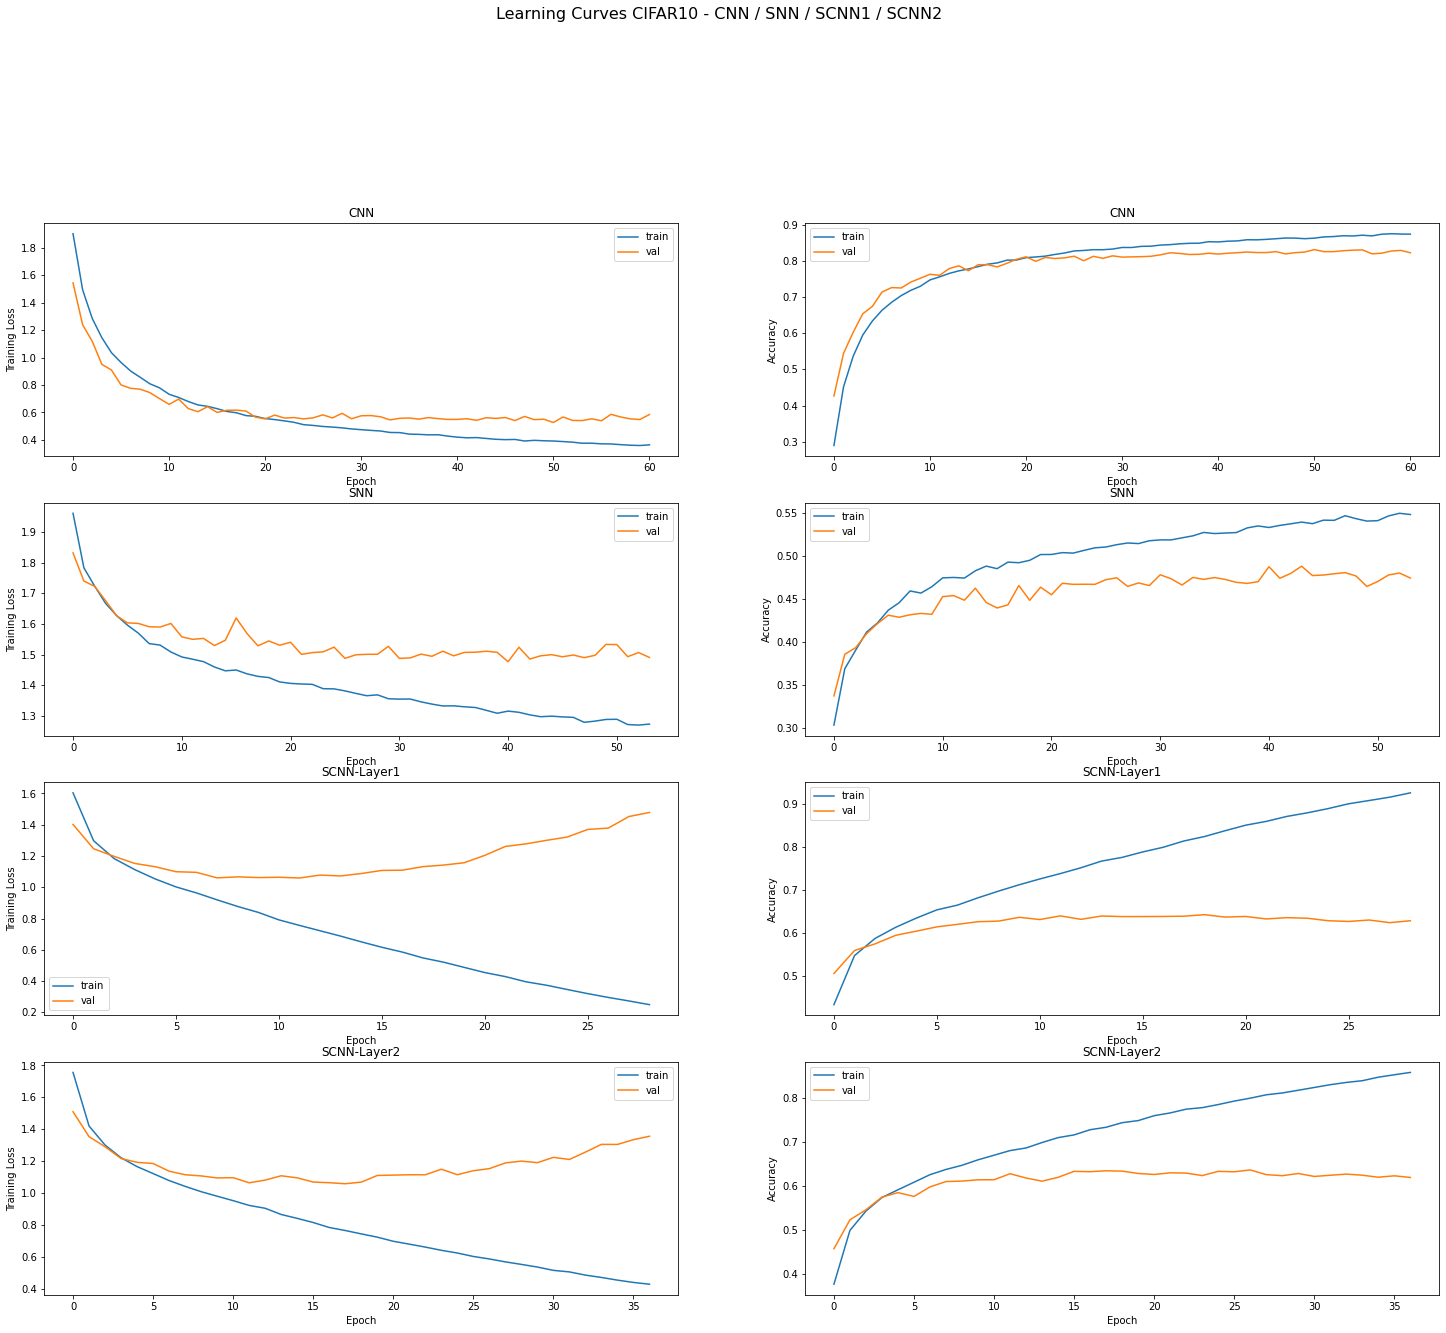

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves CIFAR10 - CNN / SNN / SCNN1 / SCNN2', fontsize=16)
fig.set_size_inches(25, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_cnn, label='train');
plt.plot(loss_test_cnn, label='val');
plt.legend();
plt.title('CNN')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_cnn, label='train');
plt.plot(acc_test_cnn, label='val');
plt.legend();
plt.title('CNN')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_snn, label='train');
plt.plot(loss_test_snn, label='val');
plt.legend();
plt.title('SNN')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_snn, label='train');
plt.plot(acc_test_snn, label='val');
plt.legend();
plt.title('SNN')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_scnn1, label='train');
plt.plot(loss_test_scnn1, label='val');
plt.legend();
plt.title('SCNN-Layer1')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_scnn1, label='train');
plt.plot(acc_test_scnn1, label='val');
plt.legend();
plt.title('SCNN-Layer1')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_scnn2, label='train');
plt.plot(loss_test_scnn2, label='val');
plt.legend();
plt.title('SCNN-Layer2')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_scnn2, label='train');
plt.plot(acc_test_scnn2, label='val');
plt.legend();
plt.title('SCNN-Layer2')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

## Accuracy Evaluation on the Test Set

In [ ]:
# Evaluate CNN
cifar_model = get_CNN_model()
cifar_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_CIFAR.h5')
score, acc = cifar_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate SNN
cifar_model = get_SNN_model(hidden_layers=180, name='SNN')
cifar_model = keras.models.load_model('SNN_CIFAR10.h5')
score, acc = cifar_model.evaluate(x_acc_test_snn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate SCNN
cifar_model = get_SCNN_model_layer1(channels=16)
cifar_model = keras.models.load_model('SCNN_CIFAR.h5')
score, acc = cifar_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate SCNN
cifar_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=128)
cifar_model = keras.models.load_model('SCNN_CIFAR.h5')
score, acc = cifar_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

## CNN Model Distillation - SNN

In [ ]:
# Load the model
cifar_model = get_CNN_model()
cifar_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_CIFAR.h5')
cifar_model.summary()

### Get the hard logits from the Teacher Model

In [ ]:
def get_logits(cifar_model, x_train, x_test):

  # Get the hard logits from the model
  cifar_model = Model(cifar_model.input, cifar_model.get_layer('logit').output)
  train_logits_hard = cifar_model.predict(x_train)
  test_logits_hard = cifar_model.predict(x_test)

  return train_logits_hard, test_logits_hard

### Adjust the Shallow Architecture to Export Logits

In [ ]:
def adjust_model(cifar_model, name):

  # Normal probabilities from logits before softmax activation
  logits = cifar_model.get_layer('logit').output
 
  # Now the model will output 10 dimensional logits
  output = logits
  cifar_model = Model(cifar_model.input, output, name=name)
  
  return cifar_model

### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

x_train_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_snn.npy')
x_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_snn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn_extra_cifar.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn_extra_cifar.npy')

x_train_snn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_snn_extra_cifar.npy')
x_test_snn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_snn_extra_cifar.npy')

x_acc_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_snn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')

### Training


In [ ]:
# Arrays with the results
scores_hidden_layers = []
hidden_layers_number = []

loss_val_hidden_layers = []
loss_train_hidden_layers = []

acc_val_hidden_layers = []
acc_train_hidden_layers = []

layers_to_test = [180, 512, 2000, 6000]

for hidden_layers in layers_to_test:
  # Set name
  name = 'SNN-CIFAR-h'+ str(hidden_layers)
  cifar_model = get_CNN_model()
  cifar_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_CIFAR.h5')
  train_logits, test_logits = get_logits(cifar_model, x_train_cnn, x_test_cnn)
  cifar_model = get_SNN_model(hidden_layers=hidden_layers, name='SNN')
  cifar_model = adjust_model(cifar_model, name)
  cifar_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  #Save trained SNN model
  cifar_model = train_snn(cifar_model, x_train_snn, train_logits, x_test_snn, test_logits, 'val_accuracy')

  # Learning Curves
  loss_train_cnn=cifar_model.history.history['loss']
  loss_val_cnn=cifar_model.history.history['val_loss']
  acc_train_cnn=cifar_model.history.history['accuracy']
  acc_val_cnn=cifar_model.history.history['val_accuracy']
  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SNN_MIMIC_CIFAR_h'+str(hidden_layers)+'.h5'
  cifar_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  cifar_model = get_SNN_model(hidden_layers=hidden_layers, name='SNN')
  cifar_model = adjust_model(cifar_model, name)
  cifar_model = keras.models.load_model(name_to_store)

  output = cifar_model.layers[-1].output
  output = Activation('softmax')(output)
  cifar_model = Model(cifar_model.input, output, name=name)

  score = 0;
  preds = cifar_model.predict(x_acc_test_snn)
  for i in range (len(x_acc_test_snn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/10000.0
  print ("Test Accuracy: %.5f" % score)
  scores_hidden_layers.append(score)
  hidden_layers_number.append(hidden_layers)

  print ('----------------------------')

### Results

#### Accuracy Results - Adam

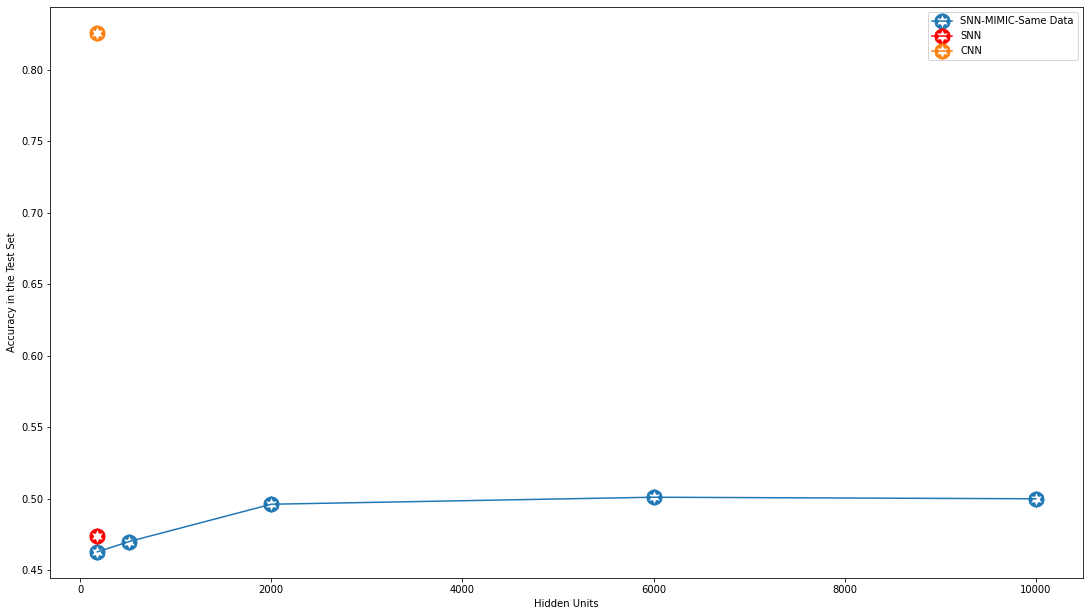

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([180, 512, 2000, 6000, 10000], [0.46280, 0.47000, 0.49610, 0.50100, 0.49990], label='SNN-MIMIC-Same Data', marker=cut_star, markersize=15)
plt.plot(180, 0.47360, marker=cut_star, markersize=15, color="red" ,label='SNN')
plt.plot(180, 0.82560, marker=cut_star, markersize=15, label='CNN')
plt.xlabel('Hidden Units');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

#### Learning Curves for Same Data - Adam


In [ ]:
loss_train_180 =[63.26152186279297, 54.08257827148437, 50.84754122314453, 48.53818584594727, 46.837688452148434, 45.49919141845703, 44.61923118286133, 43.339524719238284, 42.792860412597655, 41.94437205200195, 41.30697905273438, 40.50405113220215, 39.897133227539065, 39.4972518737793, 38.85496734924316, 38.34696594848633, 38.06373553771973, 37.446675561523435, 37.54420266723633, 36.86869487915039, 36.80324816894531, 36.291153454589846, 35.986117407226565, 35.58019958190918, 35.36428482666015, 35.260229180908205, 34.73037947387695, 34.80510250854492, 34.57642237854004, 34.25900877685547, 34.262900244140624, 33.93139676513672, 33.63964790039063, 33.21621758422852, 33.404012347412106, 33.002933251953124, 32.74589763793945, 32.63552150268555, 32.68802692871094, 32.50244337158203, 32.196398107910156, 32.099268719482424, 31.90051215209961, 31.778012762451173, 31.54474938354492, 31.494636822509765, 31.47673864440918, 31.033172094726563, 31.27281550292969, 30.904057391357423, 30.622506951904295, 30.69983179321289, 31.030816931152344, 30.446865811157227, 30.232196472167967, 30.23610712890625, 30.07891106567383, 29.730650988769533, 30.098487548828125, 29.865683465576172, 29.613045346069335, 29.640100659179687, 29.47584203491211, 29.166355004882814, 29.28451664428711, 29.368602017211913, 29.302645172119142, 29.164743411254882, 28.95517880859375, 28.821552584838866, 28.572526586914062, 28.680944412231444, 28.323143786621095, 28.409408584594726, 28.669868228149415, 28.190725952148437, 28.4395581451416]
loss_test_180 =[55.3118756652832, 51.04634123535156, 47.94052237548828, 47.13063272705078, 46.72306599731445, 46.38721954345703, 43.5444182434082, 43.85219016113281, 43.50859998779297, 43.691360900878905, 41.65108819580078, 41.071197857666014, 40.57242987060547, 40.55716474609375, 39.786751416015626, 41.31250869140625, 39.315152722167966, 39.249698580932616, 38.86086844482422, 40.07713083496094, 39.075398345947264, 38.35452493896484, 38.29261671142578, 37.88961435546875, 38.46288044433594, 38.046046661376955, 38.34647907714844, 38.27703732604981, 39.04371811523438, 38.52646298828125, 38.18012876586914, 37.64834572753906, 38.238012020874024, 38.051536080932614, 38.367954766845706, 38.18402672119141, 38.429234875488284, 38.14810061035156, 37.32758650512695, 37.08573541870117, 37.63832180175781, 37.79632328491211, 37.53159133605957, 38.15525322265625, 37.374084918212894, 37.620297662353515, 37.64284306640625, 37.86222440795898, 37.67690078430176, 37.25686029052734, 37.20857969055176, 38.06880443725586, 38.44324876708984, 39.01607269287109, 36.951090069580076, 37.968364025878905, 37.15404570922851, 37.41713459472656, 37.122046484375, 37.453184057617186, 37.670918969726564, 38.177748767089845, 38.23810968017578, 37.09517216796875, 38.1997283203125, 38.16325544128418, 38.08629312744141, 37.41667890319824, 37.217842779541016, 37.403968341064456, 37.624470703125, 37.21516203613281, 38.28086341552734, 38.13228236694336, 37.83765760498047, 37.59510821533203, 37.40839492492676]
acc_train_180 =[0.254, 0.323675, 0.35085, 0.365775, 0.37725, 0.390575, 0.397575, 0.4112, 0.412875, 0.420975, 0.422675, 0.43125, 0.435075, 0.439475, 0.441725, 0.448025, 0.447725, 0.453125, 0.45145, 0.459575, 0.458925, 0.463175, 0.464775, 0.466025, 0.468825, 0.471275, 0.472, 0.471375, 0.47275, 0.474725, 0.47555, 0.4766, 0.480075, 0.480725, 0.4804, 0.4851, 0.48505, 0.485025, 0.484675, 0.4855, 0.487425, 0.4881, 0.4887, 0.48985, 0.491225, 0.491575, 0.491975, 0.49495, 0.493875, 0.495825, 0.497175, 0.49835, 0.49525, 0.49795, 0.49925, 0.498875, 0.50365, 0.5021, 0.502425, 0.500575, 0.5021, 0.501775, 0.5031, 0.5045, 0.5045, 0.505275, 0.503325, 0.5072, 0.505925, 0.5077, 0.509675, 0.5085, 0.51005, 0.510525, 0.5086, 0.508925, 0.5083]
acc_test_180 =[0.3142000138759613, 0.3531999886035919, 0.36419999599456787, 0.36649999022483826, 0.3750999867916107, 0.3781000077724457, 0.4108999967575073, 0.4025000035762787, 0.415800005197525, 0.4196000099182129, 0.424699991941452, 0.4277999997138977, 0.4374000132083893, 0.4318000078201294, 0.4422000050544739, 0.42739999294281006, 0.44269999861717224, 0.43689998984336853, 0.4438000023365021, 0.43950000405311584, 0.44690001010894775, 0.445499986410141, 0.44999998807907104, 0.44999998807907104, 0.44859999418258667, 0.4496999979019165, 0.44859999418258667, 0.4521999955177307, 0.45249998569488525, 0.4375, 0.45570001006126404, 0.45840001106262207, 0.4546000063419342, 0.4537000060081482, 0.4487000107765198, 0.4496999979019165, 0.4528000056743622, 0.45879998803138733, 0.4668000042438507, 0.4629000127315521, 0.459199994802475, 0.4602000117301941, 0.45590001344680786, 0.45809999108314514, 0.4625000059604645, 0.4636000096797943, 0.4672999978065491, 0.4593999981880188, 0.46140000224113464, 0.4666999876499176, 0.46790000796318054, 0.45680001378059387, 0.4562000036239624, 0.44209998846054077, 0.46129998564720154, 0.4562999904155731, 0.4632999897003174, 0.45840001106262207, 0.4611000120639801, 0.45969998836517334, 0.4691999852657318, 0.45899999141693115, 0.4478999972343445, 0.4578999876976013, 0.4564000070095062, 0.45570001006126404, 0.4715000092983246, 0.4625999927520752, 0.46889999508857727, 0.4674000144004822, 0.45829999446868896, 0.4675999879837036, 0.44679999351501465, 0.46230000257492065, 0.4641000032424927, 0.46720001101493835, 0.46149998903274536]

loss_train_512=[62.35592097167969, 53.006789770507815, 49.88141068725586, 47.52971253051758, 45.40236135253906, 44.089904168701175, 42.89258052368164, 41.667974743652344, 40.70742451171875, 39.98394968261719, 38.86708918457031, 38.12568633422852, 37.834772372436525, 37.21125260009766, 36.423085571289064, 35.968697265625, 35.50475885620117, 34.83664332885742, 35.02549575195312, 34.0216798828125, 33.89245280761719, 33.387843347167966, 33.15290049743653, 32.61541682739258, 32.26874948120117, 31.92953234863281, 31.783023455810547, 31.466432446289062, 31.568283224487306, 30.7815375, 30.64957056274414, 30.32453286743164, 30.070449798583983, 30.17186877441406, 29.522799920654297, 29.12162635192871, 29.063578204345703]
loss_test_512 =[54.93422596435547, 51.43170390014649, 47.77294484863281, 46.322442559814455, 44.46384833984375, 42.95277752075195, 42.51599799804688, 40.97040939331055, 44.47100977783203, 39.93870219116211, 39.79037429199219, 39.45842872314453, 41.37471416015625, 39.991055932617186, 40.32069968261719, 37.812454174804685, 37.96592244873047, 38.03489387207031, 38.114647509765625, 37.71745349121094, 37.95927520751953, 36.65069404296875, 36.930683233642576, 36.4401668548584, 37.157207165527346, 36.43390165405273, 36.566190744018556, 37.214063568115236, 36.662235491943356, 36.338594952392576, 36.67802773132324, 36.36010951538086, 37.541835229492186, 35.81990386352539, 37.358704595947266, 36.24111723022461, 36.671333209228514]
acc_train_512 =[0.274125, 0.34525, 0.36925, 0.3865, 0.4003, 0.411425, 0.421325, 0.428225, 0.43705, 0.443275, 0.4452, 0.4563, 0.45795, 0.460325, 0.46835, 0.47, 0.4712, 0.476975, 0.479275, 0.485325, 0.486975, 0.489675, 0.492025, 0.49455, 0.5, 0.5011, 0.502125, 0.502875, 0.50645, 0.508075, 0.512475, 0.5103, 0.5134, 0.5122, 0.516925, 0.5205, 0.522625]
acc_test_512 =[0.34130001068115234, 0.3612000048160553, 0.3833000063896179, 0.3919999897480011, 0.41190001368522644, 0.4140999913215637, 0.43130001425743103, 0.43709999322891235, 0.44130000472068787, 0.44020000100135803, 0.4487999975681305, 0.4438000023365021, 0.4374000132083893, 0.4429999887943268, 0.44510000944137573, 0.4569999873638153, 0.4648999869823456, 0.46810001134872437, 0.4562999904155731, 0.4542999863624573, 0.46779999136924744, 0.4778999984264374, 0.47540000081062317, 0.4717000126838684, 0.4657000005245209, 0.47929999232292175, 0.48570001125335693, 0.46399998664855957, 0.4844000041484833, 0.4805000126361847, 0.47909998893737793, 0.4814000129699707, 0.46959999203681946, 0.48190000653266907, 0.4659999907016754, 0.48089998960494995, 0.48429998755455017]

loss_train_2000 =[62.15779382324219, 52.631612805175784, 48.99583659667969, 46.72071002197266, 44.77607171630859, 43.27281448364258, 41.716603106689455, 40.45289674682617, 39.827375427246096, 38.86593823852539, 37.89602724304199, 36.98704494018555, 36.23752485961914, 36.17878084716797, 35.0900289855957, 34.677589410400394, 33.938686282348634, 33.30255776367188, 32.878340423583985, 32.6939859375, 32.06247789306641, 31.41441889038086, 31.16198414916992, 30.91147366027832, 30.288261322021484, 29.947132788085938, 29.457883813476563, 29.263110775756836, 28.89011668701172, 28.493046392822265, 28.123487661743162, 28.08145425415039, 27.91283369445801, 27.44377572631836, 26.861657971191406, 26.875332849121094, 26.237286953735353, 26.49666782836914, 26.026342504882813, 25.54951188964844, 25.489276986694335, 25.28354848022461, 24.783054196166994, 24.649571673583985, 24.591599130249023, 24.035623260498046, 24.030906176757814, 23.865964376831055, 23.567105096435547, 23.136809866333007, 23.144865069580078, 23.10677545776367, 22.64027744140625, 22.664162713623046, 22.35063761291504, 22.07609471130371, 21.89113727416992, 21.78282689819336, 21.561590325927735, 21.359160525512696]
loss_test_2000 =[53.106746875, 48.35947242431641, 47.14219152832031, 47.90097041015625, 45.526749395751956, 43.58100084228516, 45.036109027099606, 42.971258435058594, 40.8664839050293, 41.58113449707031, 39.174085766601564, 38.402805181884766, 38.41653006591797, 38.21117142333984, 38.17446465454102, 38.91564129638672, 36.765642803955075, 39.615927294921875, 36.924115313720705, 36.42848867492676, 37.772097998046874, 36.37209475402832, 38.115747509765626, 36.608930474853516, 36.260295712280275, 36.226310235595705, 36.37175208740234, 35.71510061035156, 36.77293840942383, 35.17080916137695, 36.12695945129394, 36.2012505859375, 36.08593957519531, 35.408181768798826, 36.143323040771485, 35.38642125244141, 35.25991481933594, 37.50262623291015, 35.14323728942871, 36.823601336669924, 35.028312548828126, 35.637884063720705, 35.722033813476564, 35.35656597595215, 36.38507583618164, 36.63838934326172, 36.3860322265625, 36.39457538452148, 36.34314763183594, 35.26058449401855, 35.624522216796876, 35.62487744750977, 36.61082246704102, 36.009468270874024, 35.65808207397461, 36.28449217224121, 35.42221943054199, 35.724995874023435, 35.423097732543944, 36.82356284790039]
acc_train_2000 =[0.280725, 0.3459, 0.374, 0.39185, 0.408625, 0.4229, 0.432875, 0.4403, 0.4483, 0.45265, 0.463025, 0.465825, 0.473775, 0.47745, 0.48065, 0.483425, 0.4907, 0.4941, 0.499525, 0.50215, 0.505875, 0.50885, 0.510825, 0.51265, 0.51755, 0.52145, 0.524275, 0.526525, 0.530825, 0.531375, 0.534075, 0.53415, 0.53755, 0.539, 0.54455, 0.54215, 0.549325, 0.5482, 0.550425, 0.551575, 0.5525, 0.5544, 0.56085, 0.558675, 0.5619, 0.56415, 0.564625, 0.568125, 0.56925, 0.56975, 0.569425, 0.5717, 0.575775, 0.5761, 0.576125, 0.57855, 0.582875, 0.58245, 0.584775, 0.5868]
acc_test_2000 =[0.33309999108314514, 0.3765000104904175, 0.38040000200271606, 0.39660000801086426, 0.40959998965263367, 0.4115999937057495, 0.42239999771118164, 0.439300000667572, 0.43689998984336853, 0.4259999990463257, 0.4537000060081482, 0.4560999870300293, 0.46129998564720154, 0.47099998593330383, 0.45559999346733093, 0.4514000117778778, 0.4758000075817108, 0.4507000148296356, 0.46959999203681946, 0.4643000066280365, 0.4560000002384186, 0.48069998621940613, 0.4778999984264374, 0.475600004196167, 0.4837000072002411, 0.48570001125335693, 0.4867999851703644, 0.4900999963283539, 0.48420000076293945, 0.4943000078201294, 0.4864000082015991, 0.4812999963760376, 0.4893999993801117, 0.4936999976634979, 0.4788999855518341, 0.4943000078201294, 0.4950000047683716, 0.49059998989105225, 0.4934000074863434, 0.4943999946117401, 0.49549999833106995, 0.48840001225471497, 0.49630001187324524, 0.5026999711990356, 0.4984000027179718, 0.4943999946117401, 0.5033000111579895, 0.4952000081539154, 0.48350000381469727, 0.5092999935150146, 0.5016999840736389, 0.5, 0.49399998784065247, 0.5022000074386597, 0.4936000108718872, 0.4964999854564667, 0.4959999918937683, 0.49950000643730164, 0.5024999976158142, 0.4997999966144562]

loss_train_6000 =[63.15904183959961, 52.390274652099606, 48.501338372802735, 46.1507103515625, 44.04124783935547, 43.378570141601564, 41.74902626953125, 40.38745639038086, 39.296530725097654, 38.27586189575195, 37.62236623535156, 36.83614099121094, 36.03481481628418, 35.51366378479004, 34.96686845703125, 34.13056382446289, 33.53755341491699, 32.95156685791016, 33.11923532714844, 32.18044580078125, 31.495669793701172, 31.10998973083496, 30.82145155029297, 30.60358787841797, 29.911828820800782, 29.504387512207032, 29.334169360351563, 28.588980004882814, 28.397684146118163, 27.8329790435791, 27.72536883544922, 27.21789582824707, 27.237887579345703, 26.87571919250488, 26.394210876464843, 25.888919393920897, 25.887467492675782, 25.575723962402343, 25.15929291381836, 24.76158148803711, 24.687670770263672, 24.26373123168945, 24.099451007080077, 24.059721392822265, 23.657092834472657, 23.63542908630371, 22.87544197998047, 22.867097662353515, 22.71003047180176, 22.48170365905762, 22.44680599975586, 22.101004638671874, 21.878481274414064, 21.57435876159668, 21.411425958251954, 21.485686178588868, 21.14558635559082]
loss_test_6000 =[52.536812786865234, 48.61276030273437, 46.53935853271484, 45.53608327636719, 43.24045269165039, 42.42131441040039, 43.09695893554687, 40.93802342529297, 40.52405306396484, 39.18268785400391, 39.41291454467773, 39.03987385253906, 37.92235618286133, 38.81271441040039, 38.86587974243164, 37.75672254638672, 37.05694053955078, 36.47008980102539, 36.27527977294922, 35.90997202148438, 36.5613361328125, 35.51906760559082, 35.596046618652345, 36.1812360168457, 36.12407654724121, 36.82429090576172, 35.36422432250976, 35.69319621887207, 35.26761823120117, 35.64213380126953, 34.92614066162109, 35.812683666992186, 34.952945639038084, 37.49587192993164, 34.58899639892578, 35.65186915893555, 35.40824430541992, 35.10554237670898, 35.08296538696289, 35.292567346191404, 36.73476235961914, 35.24416506958008, 35.105398706054686, 35.41660778198242, 36.94232497863769, 35.08585559692383, 35.161710177612306, 36.943984240722656, 35.74844569702149, 34.93129221191406, 35.73370532836914, 36.03926142578125, 35.375545806884766, 35.22049687194824, 35.89520344848633, 36.46067503662109, 36.15575283813477]
acc_train_6000 =[0.269, 0.34465, 0.373975, 0.395775, 0.4125, 0.420725, 0.430775, 0.441225, 0.445925, 0.45365, 0.4608, 0.464875, 0.470525, 0.4775, 0.4766, 0.484475, 0.4917, 0.494175, 0.492975, 0.501125, 0.508225, 0.508325, 0.509875, 0.51355, 0.517325, 0.52465, 0.5249, 0.52915, 0.531975, 0.537425, 0.535325, 0.5406, 0.540625, 0.54505, 0.544975, 0.549025, 0.549725, 0.55605, 0.55525, 0.559025, 0.55925, 0.5607, 0.5633, 0.56695, 0.567825, 0.56945, 0.5731, 0.57255, 0.5749, 0.5767, 0.579925, 0.580825, 0.5831, 0.58775, 0.588, 0.584625, 0.589875]
acc_test_6000 =[0.3361999988555908, 0.36640000343322754, 0.39579999446868896, 0.40639999508857727, 0.4104999899864197, 0.40560001134872437, 0.4368000030517578, 0.42579999566078186, 0.4478999972343445, 0.44589999318122864, 0.4453999996185303, 0.45820000767707825, 0.4578000009059906, 0.4611000120639801, 0.45260000228881836, 0.4747999906539917, 0.46790000796318054, 0.47940000891685486, 0.4715999960899353, 0.47850000858306885, 0.4756999909877777, 0.47699999809265137, 0.478300005197525, 0.4830999970436096, 0.4887000024318695, 0.4896000027656555, 0.48829999566078186, 0.48829999566078186, 0.4927999973297119, 0.49570000171661377, 0.49619999527931213, 0.48969998955726624, 0.5041999816894531, 0.4848000109195709, 0.5013999938964844, 0.4970000088214874, 0.5, 0.4943999946117401, 0.5080000162124634, 0.5031999945640564, 0.49399998784065247, 0.5001000165939331, 0.5042999982833862, 0.5001000165939331, 0.5008999705314636, 0.5076000094413757, 0.5149999856948853, 0.4943999946117401, 0.5044999718666077, 0.49970000982284546, 0.49810001254081726, 0.5078999996185303, 0.5049999952316284, 0.5012999773025513, 0.5066999793052673, 0.49570000171661377, 0.49810001254081726]

loss_train_10000 =[64.04263267822266, 52.403143310546874, 49.101630541992186, 46.27458469238281, 44.56403740844726, 42.92113659667969, 41.65617592163086, 40.62654373168945, 39.34247043762207, 38.49617891845703, 37.94477424926758, 36.84117866210938, 35.90945675048828, 35.55627755737304, 34.67505072937012, 33.86071997680664, 33.485760339355465, 33.06239666442871, 32.29644084472656, 31.976753805541993, 31.509471868896483, 30.947022702026366, 30.28931207885742, 30.14370913696289, 29.90337759399414, 29.07541440734863, 29.098857556152343, 28.372136907958986, 28.03671533203125, 27.747052130126953, 27.29542144470215, 27.24841517944336, 26.852657641601564, 26.456719342041016, 26.250124615478516, 25.833456176757814, 25.753656286621094, 25.354307940673827, 25.33270202026367, 24.8234927734375, 24.63340832519531, 24.434164141845702, 23.740283569335936, 23.773816778564452, 23.56922681274414, 23.023297158813477, 23.25584138183594, 22.822127227783202, 22.860904351806642, 22.299428552246095, 22.32994963989258, 21.98046301879883, 21.845911917114258, 21.49518512878418, 21.620981524658202, 21.1036701965332, 21.188281939697266, 20.673214755249024, 20.85368165588379, 20.77904579772949, 20.294409274291993, 20.141682202148438, 19.93654270324707, 19.69848595275879, 19.714629779052736, 19.43991424560547, 19.403156988525392, 19.104204751586913, 19.01111755065918, 18.93402005004883, 18.811448388671874, 18.673360986328124, 18.414498043823244, 18.61138377685547, 18.373286080932616, 18.011690007019045, 18.05022357788086, 17.86706586303711, 17.831882205200195]
loss_test_10000 =[53.277040844726564, 52.6719033203125, 46.406321868896484, 46.86007344360352, 43.66788001098633, 43.09669149169922, 41.94685456542969, 41.15739624023438, 40.49311583251953, 40.22070910644531, 39.86034008178711, 40.26228431396484, 37.633044387817385, 38.01142622070312, 37.28161891479492, 36.98341120605469, 37.58492336425781, 36.412785281372074, 38.65110930480957, 39.08088439941406, 36.05622619018555, 36.29894571228027, 35.76294829711914, 37.65430090637207, 35.19262603149414, 35.71092231750488, 35.483899151611325, 35.3147513885498, 36.54550057373047, 35.264073574829105, 35.60583657836914, 36.23590140380859, 35.68896303100586, 35.09641221313476, 34.94358585205078, 35.31644776916504, 35.45028856811523, 36.99087003173828, 37.31042008666992, 35.32832034912109, 36.0891897277832, 35.04315493774414, 35.19351265258789, 35.43681613769531, 34.94192631225586, 35.76185845336914, 35.2561538482666, 37.46201546630859, 39.08611917114258, 38.4537611328125, 35.35514270629883, 35.50761764831543, 36.313200842285156, 35.532791278076175, 35.42464804992676, 35.02417847290039, 37.108389367675784, 36.07217026367187, 36.286548742675784, 35.750501083374026, 36.0793946685791, 37.153462783813474, 35.46744971923828, 35.63438682861328, 35.24848255004883, 35.682428619384766, 35.94727742919922, 35.57206265869141, 35.73603373413086, 35.61505213623047, 36.838142242431644, 35.96164234313965, 36.018711526489255, 35.520591748046876, 36.687837289428714, 36.28956241455078, 36.263553607177734, 36.484676129150394, 35.82835081481934]
acc_train_10000=[0.265825, 0.344425, 0.369825, 0.39355, 0.407425, 0.4207, 0.4306, 0.436675, 0.4478, 0.4553, 0.4621, 0.466525, 0.47475, 0.477875, 0.485375, 0.4907, 0.491225, 0.49525, 0.499525, 0.503225, 0.5053, 0.510975, 0.5152, 0.517575, 0.517625, 0.523575, 0.524075, 0.5281, 0.531725, 0.5343, 0.537125, 0.536975, 0.540575, 0.544725, 0.54755, 0.5475, 0.550425, 0.553375, 0.5543, 0.557175, 0.559675, 0.55935, 0.56495, 0.56505, 0.568325, 0.569975, 0.5693, 0.575625, 0.574525, 0.577725, 0.578825, 0.581875, 0.582325, 0.58445, 0.58425, 0.588575, 0.5887, 0.591325, 0.593025, 0.5932, 0.594325, 0.595775, 0.59765, 0.599175, 0.59895, 0.602625, 0.603675, 0.60715, 0.604975, 0.607025, 0.6062, 0.6093, 0.61185, 0.61205, 0.61145, 0.6143, 0.613975, 0.617025, 0.61645]
acc_test_10000 =[0.3336000144481659, 0.35690000653266907, 0.3865000009536743, 0.39469999074935913, 0.412200003862381, 0.4320000112056732, 0.4260999858379364, 0.4388999938964844, 0.4458000063896179, 0.44339999556541443, 0.4449999928474426, 0.44440001249313354, 0.46399998664855957, 0.44920000433921814, 0.45159998536109924, 0.4677000045776367, 0.4675999879837036, 0.47699999809265137, 0.46970000863075256, 0.460999995470047, 0.4747999906539917, 0.48069998621940613, 0.4763000011444092, 0.48089998960494995, 0.4810999929904938, 0.4779999852180481, 0.48660001158714294, 0.4867999851703644, 0.4853000044822693, 0.48980000615119934, 0.4828000068664551, 0.48019999265670776, 0.49149999022483826, 0.4961000084877014, 0.492000013589859, 0.4957999885082245, 0.49709999561309814, 0.4878000020980835, 0.48890000581741333, 0.48579999804496765, 0.490200012922287, 0.4993000030517578, 0.4936000108718872, 0.49570000171661377, 0.5059000253677368, 0.5026000142097473, 0.49619999527931213, 0.48809999227523804, 0.49459999799728394, 0.4945000112056732, 0.5088000297546387, 0.5006999969482422, 0.5004000067710876, 0.49380001425743103, 0.4991999864578247, 0.5062000155448914, 0.5048999786376953, 0.5030999779701233, 0.5030999779701233, 0.5120000243186951, 0.4975000023841858, 0.5073000192642212, 0.508899986743927, 0.5123999714851379, 0.5059999823570251, 0.5084999799728394, 0.5127999782562256, 0.5127999782562256, 0.5133000016212463, 0.5102999806404114, 0.5026000142097473, 0.5081999897956848, 0.5047000050544739, 0.5095999836921692, 0.503000020980835, 0.5047000050544739, 0.5009999871253967, 0.5063999891281128, 0.5051000118255615]


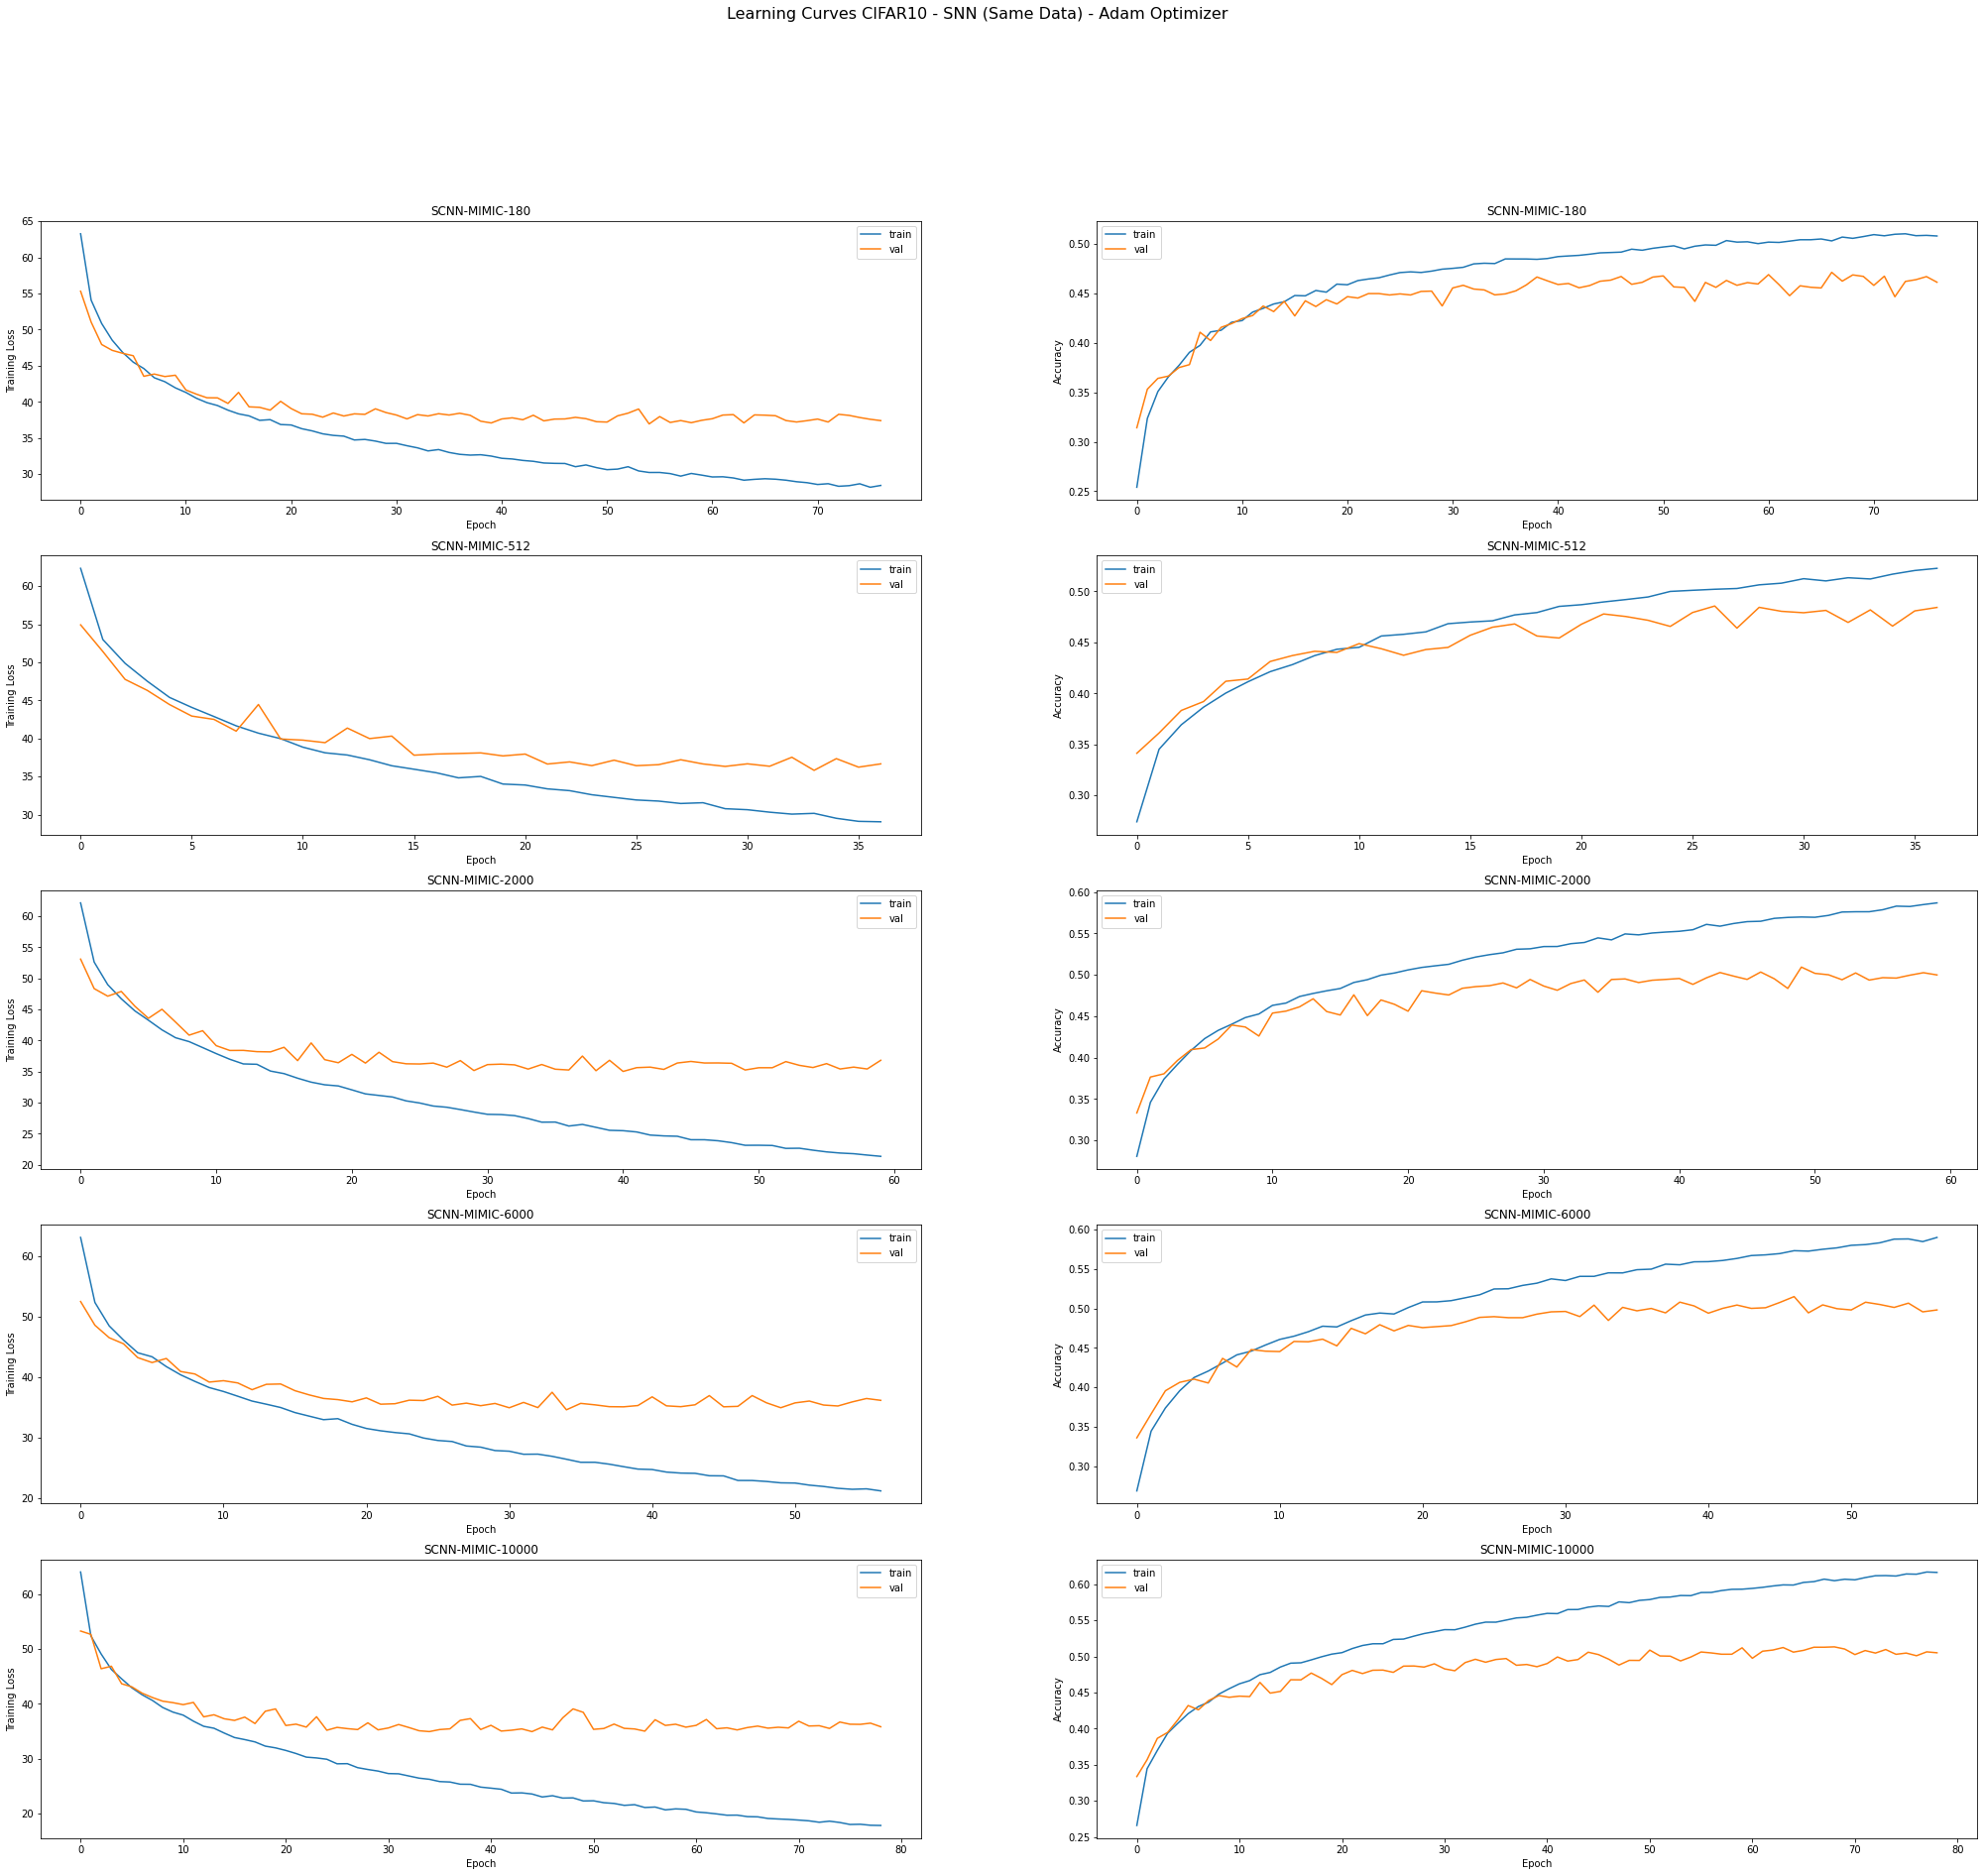

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves CIFAR10 - SNN (Same Data) - Adam Optimizer', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(5, 2, 1)
plt.plot(loss_train_180, label='train');
plt.plot(loss_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(5, 2, 2)
plt.plot(acc_train_180, label='train');
plt.plot(acc_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(5, 2, 3)
plt.plot(loss_train_512, label='train');
plt.plot(loss_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(5, 2, 4)
plt.plot(acc_train_512, label='train');
plt.plot(acc_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(5, 2, 5)
plt.plot(loss_train_2000, label='train');
plt.plot(loss_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(5, 2, 6)
plt.plot(acc_train_2000, label='train');
plt.plot(acc_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(5, 2, 7)
plt.plot(loss_train_6000, label='train');
plt.plot(loss_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(5, 2, 8)
plt.plot(acc_train_6000, label='train');
plt.plot(acc_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(5, 2, 9)
plt.plot(loss_train_10000, label='train');
plt.plot(loss_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(5, 2, 10)
plt.plot(acc_train_10000, label='train');
plt.plot(acc_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

## CNN Model Distillation - Shallow CNNs

### Get the hard logits from the Teacher Model

In [ ]:
def get_logits(cifar_model, x_train, x_test):

  # Get the hard logits from the model
  cifar_model = Model(cifar_model.input, cifar_model.get_layer('logit').output)
  train_logits_hard = cifar_model.predict(x_train)
  test_logits_hard = cifar_model.predict(x_test)

  return train_logits_hard, test_logits_hard

### Adjust the Shallow Architecture to Export Logits

In [ ]:
def adjust_model(cifar_model, name):

  # Normal probabilities from logits before softmax activation
  logits = cifar_model.get_layer('logit').output
 
  # Now the model will output 10 dimensional logits
  output = logits
  cifar_model = Model(cifar_model.input, output, name=name)
  
  return cifar_model

### Training / Evaluation for 1 Layer

#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn_extra_cifar.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn_extra_cifar.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')

#### Training

In [ ]:
# Arrays with the results
scores_1_layer = []
channels_number = []

channels_to_test = [16,64,256,384]

for channel in channels_to_test:
  # Set name
  name = 'SCNN-CIFAR-h'+ str(channel)
  cifar_model = get_CNN_model()
  cifar_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_CIFAR.h5')
  train_logits, test_logits = get_logits(cifar_model, x_train_cnn_extra, x_test_cnn_extra)
  cifar_model = get_SCNN_model_layer1(channels=channel)
  cifar_model = adjust_model(cifar_model, name)
  cifar_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  #Save trained SCNN model
  cifar_model = train_scnn(cifar_model, x_train_cnn_extra, train_logits, x_test_cnn_extra, test_logits)

  # Learning Curves
  loss_train_cnn=cifar_model.history.history['loss']
  loss_val_cnn=cifar_model.history.history['val_loss']
  acc_train_cnn=cifar_model.history.history['accuracy']
  acc_val_cnn=cifar_model.history.history['val_accuracy']

  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SCNN_MIMIC_CIFAR_h'+str(channel)+'.h5'
  cifar_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  cifar_model = get_SCNN_model_layer1(channels=channel)
  cifar_model = adjust_model(cifar_model, name)
  cifar_model = keras.models.load_model(name_to_store)

  output = cifar_model.layers[-1].output
  output = Activation('softmax')(output)
  cifar_model = Model(cifar_model.input, output, name=name)

  score = 0;
  preds = cifar_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/10000.0
  print ("Test Accuracy: %.5f" % score)
  scores_1_layer.append(score)
  channels_number.append(channel)

  import shutil
  shutil.move("/content/"+name_to_store, "/content/drive/My Drive/"+name_to_store)

  print ('----------------------------')

#### Results

##### Accuracy Results - Adam

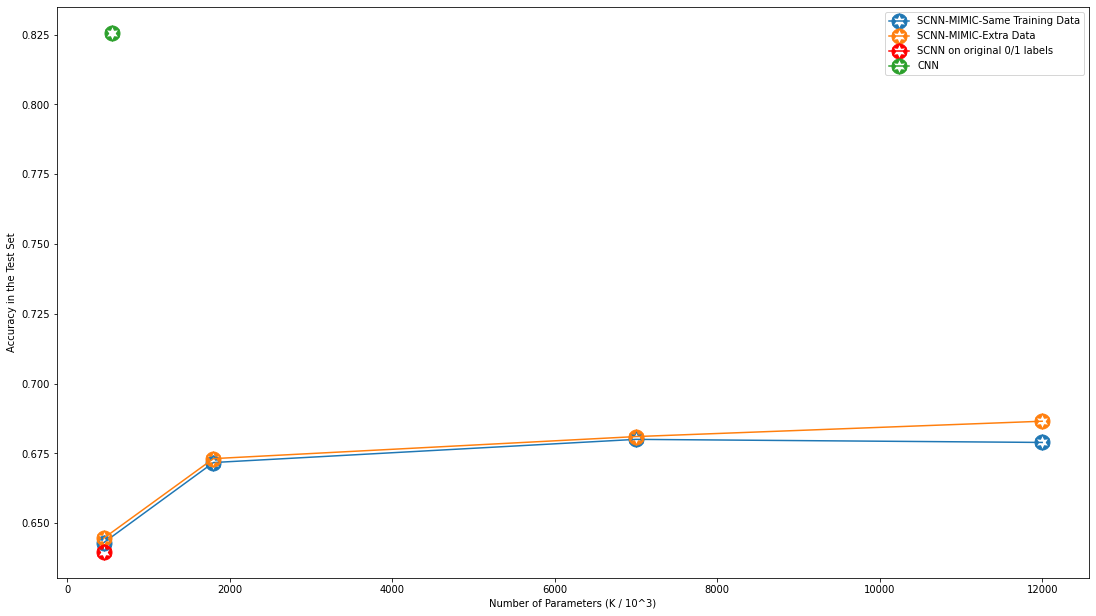

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([450, 1800, 7000, 12000], [0.64300, 0.67170, 0.68000, 0.67890], label='SCNN-MIMIC-Same Training Data', marker=cut_star, markersize=15)
plt.plot([450, 1800, 7000, 12000], [0.64460, 0.67310, 0.68100, 0.68650], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot(450, 0.63970, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(550, 0.82560, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Learning Curves for Same Data - Adam

In [ ]:
loss_train_16=[55.57531680908203, 39.14349659423828, 34.88753115844727, 32.07307343139649, 30.346439349365234, 28.545872509765626, 27.07742531738281, 25.768737841796874, 24.652309677124023, 23.825349645996095, 22.81415078125, 22.128937060546875, 21.430799438476562, 20.652226779174804, 19.817479461669922, 19.14146746520996, 18.47396976928711, 18.004876068115234, 17.510029440307616, 17.031941665649413, 16.578637045288087, 16.09346558227539, 15.672732501220704, 15.264713563537597, 14.949780813598633, 14.559005737304688, 14.126143254089355, 13.833787728881836, 13.626809605407715, 13.250906076049805, 12.947384141540528, 12.742498135375977, 12.461733541870117, 12.339452992248535, 11.966069927978516, 11.748389178466796, 11.446504359436036, 11.330373393249511, 11.214350036621093, 10.909010522460937, 10.741033947753905, 10.513134063720702, 10.40945764465332, 10.24574432067871, 10.065172805786133, 9.84838517150879, 9.841156423950196, 9.5656689453125, 9.450705314636231, 9.306382342529297, 9.180405387878418, 9.110555531311036, 8.873408941650391, 8.75152981262207]
loss_test_16 =[42.32859323730469, 36.28216042480469, 33.03530454101563, 30.817054077148438, 29.39603865661621, 28.27175887451172, 27.542988110351562, 25.73389387207031, 24.942136553955077, 24.466699548339843, 24.143973168945312, 23.948460690307616, 22.531161553955076, 23.45664312133789, 21.805618551635742, 21.53462637939453, 21.481437548828126, 20.784758459472656, 20.487037426757812, 20.479461434936525, 20.264368759155275, 20.652567892456055, 19.78203297729492, 20.015384552001954, 19.647158462524413, 19.778994348144533, 19.518024139404297, 19.35426459350586, 20.777009478759766, 19.622355920410158, 19.573406506347656, 19.695508767700197, 19.319350213623046, 19.570398376464844, 19.40173493347168, 19.49040717163086, 19.114815518188475, 19.385857345581055, 19.42806212158203, 19.13489282836914, 19.199308227539063, 19.273480639648437, 19.29534214477539, 19.374782550048828, 19.725240438842775, 19.48518699951172, 19.327200579833985, 19.48252684020996, 19.488583218383788, 19.526685804748535, 19.866919786071776, 20.025423651123045, 19.84149553527832, 19.99471978149414]
acc_train_16 =[0.298625, 0.4134, 0.462725, 0.497325, 0.51935, 0.536775, 0.55185, 0.561175, 0.573925, 0.582775, 0.593375, 0.599475, 0.6082, 0.61615, 0.621375, 0.62945, 0.634125, 0.64095, 0.64405, 0.649725, 0.654275, 0.660575, 0.66325, 0.66825, 0.6697, 0.677125, 0.67925, 0.683025, 0.685225, 0.687925, 0.691975, 0.694425, 0.696625, 0.6993, 0.70325, 0.704825, 0.70795, 0.70785, 0.7089, 0.71205, 0.713425, 0.717775, 0.71785, 0.718525, 0.722325, 0.724575, 0.724, 0.726525, 0.728875, 0.728475, 0.73025, 0.731375, 0.733225, 0.735775]
acc_test_16 =[0.383899986743927, 0.4562000036239624, 0.5044999718666077, 0.5206000208854675, 0.5430999994277954, 0.5548999905586243, 0.5648000240325928, 0.5766000151634216, 0.5794000029563904, 0.5888000130653381, 0.5896999835968018, 0.602400004863739, 0.6083999872207642, 0.6134999990463257, 0.6180999875068665, 0.6234999895095825, 0.6304000020027161, 0.633400022983551, 0.6388999819755554, 0.6409000158309937, 0.6406000256538391, 0.6406000256538391, 0.6445000171661377, 0.6525999903678894, 0.6498000025749207, 0.6520000100135803, 0.6579999923706055, 0.6614000201225281, 0.6449999809265137, 0.6541000008583069, 0.6635000109672546, 0.6672000288963318, 0.6625000238418579, 0.6589999794960022, 0.6572999954223633, 0.6647999882698059, 0.6697999835014343, 0.6678000092506409, 0.6614000201225281, 0.669700026512146, 0.6668999791145325, 0.6628000140190125, 0.6707000136375427, 0.6740000247955322, 0.6700999736785889, 0.669700026512146, 0.6729000210762024, 0.664900004863739, 0.6721000075340271, 0.6682999730110168, 0.6672000288963318, 0.6723999977111816, 0.6694999933242798, 0.6725999712944031]

loss_train_64 =[48.290795083618164, 33.89890469970703, 29.273001171875, 25.82110160522461, 23.455527462768554, 21.50280797729492, 20.309016757202148, 18.706500451660155, 17.688332067871094, 16.954891961669922, 15.87808217010498, 15.045146731567383, 14.302055700683594, 13.657194305419923, 13.078064553833007, 12.367486576843262, 11.857130444335937, 11.416714840698242, 10.919333248901367, 10.49427707824707, 10.01455205230713, 9.656410232543946, 9.240835020446777, 8.85984654006958, 8.553298161315919, 8.173368096923829, 7.899827481079101, 7.661105888366699, 7.2285006195068355, 7.125886855316162, 6.821601956176758, 6.578992250061035, 6.378749415588379, 6.200634842681885, 6.038772570037842, 5.7855077056884765, 5.605562266540527, 5.4254814125061035, 5.361957374572754, 5.111249041748047, 4.987619474029541, 4.806409114837646, 4.731395862579346, 4.600456167602539, 4.487572201538086]
loss_test_64 =[37.295469635009766, 31.168245520019532, 26.922988543701173, 24.826303771972658, 22.59085410461426, 23.78580521850586, 21.354188272094728, 20.401970402526857, 19.717324963378907, 18.781356192016602, 18.73402492980957, 17.94598296813965, 17.734901397705077, 17.61659245300293, 17.483607022094727, 17.193348718261717, 17.308788386535646, 17.370663204956056, 16.731457173156738, 16.72617730102539, 16.867260313415528, 16.83323901977539, 17.2671923248291, 16.57854201812744, 16.93336106262207, 16.863334646606447, 16.684328549194337, 17.081839416503907, 17.044155554199218, 16.918301095581054, 17.212872943115233, 16.952641751098632, 16.837489457702638, 17.172370655822753, 16.91344910888672, 16.997197192382814, 17.35357449951172, 17.31607505493164, 17.349106277465822, 17.241934033203126, 17.207387173461914, 17.22078981323242, 17.412236654663086, 17.682790782165526, 17.502373846435546]
acc_train_64 =[0.344575, 0.482725, 0.53935, 0.573125, 0.596825, 0.6122, 0.627125, 0.644425, 0.655525, 0.662675, 0.674525, 0.681325, 0.691475, 0.6961, 0.7001, 0.7087, 0.71595, 0.720825, 0.7233, 0.7297, 0.73375, 0.738775, 0.74355, 0.748625, 0.7513, 0.7569, 0.75725, 0.7633, 0.76925, 0.770975, 0.77465, 0.7778, 0.782975, 0.783225, 0.787225, 0.79075, 0.7947, 0.79755, 0.800075, 0.802825, 0.806, 0.810425, 0.8106, 0.8148, 0.81695]
acc_test_64 =[0.4350000023841858, 0.5181999802589417, 0.5676000118255615, 0.5996000170707703, 0.616599977016449, 0.6092000007629395, 0.6309999823570251, 0.6460000276565552, 0.6503000259399414, 0.6559000015258789, 0.6678000092506409, 0.6730999946594238, 0.6751999855041504, 0.6776000261306763, 0.6832000017166138, 0.6751000285148621, 0.6883000135421753, 0.6858000159263611, 0.6955000162124634, 0.6973000168800354, 0.694599986076355, 0.6953999996185303, 0.6940000057220459, 0.6970000267028809, 0.6973999738693237, 0.6934999823570251, 0.7021999955177307, 0.6960999965667725, 0.6992999911308289, 0.697700023651123, 0.6988000273704529, 0.6991999745368958, 0.7019000053405762, 0.70169997215271, 0.7041000127792358, 0.6973000168800354, 0.6983000040054321, 0.698199987411499, 0.6987000107765198, 0.697700023651123, 0.6991000175476074, 0.7001000046730042, 0.6996999979019165, 0.6934999823570251, 0.6991000175476074]

loss_train_256 =[43.87175123901367, 30.15408688659668, 25.094887979125975, 21.976260177612303, 19.899222665405272, 17.78574811706543, 16.19977915649414, 14.97463197479248, 13.71863904876709, 12.831070632934571, 11.87709448852539, 11.2333025680542, 10.301275663757325, 9.682104331970216, 8.997488648986817, 8.430188354492188, 7.805899299621582, 7.371179521942139, 6.899232051086425, 6.45042614440918, 6.053999825286866, 5.762721018981933, 5.44360489654541, 5.162557943725586, 4.829445751953125, 4.549782732391358, 4.332680127716064, 4.226058726501464, 3.943133191680908, 3.803746643447876, 3.6227691787719727, 3.474104883956909, 3.3798780261993406, 3.156699452972412]
loss_test_256 =[32.58710152282715, 26.279237854003906, 23.447684686279295, 21.896844747924806, 19.983409887695313, 19.467292196655272, 19.220428492736815, 18.526728729248045, 17.295920916748045, 17.253252992248534, 16.985123596191407, 16.920959352111815, 16.532065563964842, 16.265717529296875, 16.132695805358885, 16.046623803710936, 16.332347508239746, 15.900247456359864, 15.955643116760253, 16.350406689453123, 16.603094869995118, 16.317926194763185, 16.419373358154296, 16.286038729858397, 16.53383664855957, 16.452048043823243, 16.54282250671387, 16.49820841064453, 16.465343716430663, 16.64193096008301, 16.314358016967773, 16.69843807373047, 16.738496426391603, 16.661644891357422]
acc_train_256 =[0.40135, 0.53585, 0.583675, 0.617675, 0.635725, 0.657, 0.671125, 0.685275, 0.70005, 0.7096, 0.72055, 0.72625, 0.737075, 0.7446, 0.75455, 0.761425, 0.77015, 0.7758, 0.781125, 0.788275, 0.794525, 0.8006, 0.80695, 0.8108, 0.81775, 0.823425, 0.830775, 0.832475, 0.838475, 0.842575, 0.8473, 0.852225, 0.85655, 0.858775]
acc_test_256 =[0.4997999966144562, 0.5791000127792358, 0.6071000099182129, 0.6198999881744385, 0.645799994468689, 0.6646000146865845, 0.6578999757766724, 0.6758000254631042, 0.6876000165939331, 0.6766999959945679, 0.6965000033378601, 0.6984999775886536, 0.6985999941825867, 0.6955000162124634, 0.6940000057220459, 0.7006000280380249, 0.7073000073432922, 0.7114999890327454, 0.7132999897003174, 0.7102000117301941, 0.7102000117301941, 0.7035999894142151, 0.7110000252723694, 0.71670001745224, 0.7026000022888184, 0.7117000222206116, 0.710099995136261, 0.7078999876976013, 0.7071999907493591, 0.7063999772071838, 0.7081999778747559, 0.7095000147819519, 0.7075999975204468, 0.7052000164985657]

loss_train_384 =[44.35222272949219, 30.3206180847168, 25.643266693115233, 22.084380325317383, 19.797340866088867, 18.011903353881834, 16.475238256835937, 15.181361157226563, 13.924783966064453, 13.084896209716797, 12.042238410949707, 11.302300646972656, 10.534577436828613, 9.945810586547852, 9.212309024047851, 8.557479008483886, 7.919664344787598, 7.491645632171631, 7.009776950836182, 6.648631324768067, 6.195803959655762, 5.902291207885742, 5.520933419799805, 5.196492642211914, 5.01772632598877, 4.701255478668213, 4.482432962036133, 4.321375228881836, 4.108312160491943, 3.9283169921875, 3.816637469482422, 3.630073320007324, 3.512403225708008, 3.316845087814331, 3.2528259803771973, 3.215017768096924, 3.0327733039855955, 2.898171353149414, 2.834537603759766, 2.6739969955444334, 2.632599937438965, 2.5362258926391603]
loss_test_384 =[32.928807458496095, 27.58961738586426, 23.96556364440918, 21.464282318115234, 20.142805270385743, 20.071539215087892, 18.899552342224123, 18.77988081665039, 18.87946432800293, 19.279850604248047, 17.502057698059083, 17.269998056030275, 16.55463828277588, 16.780175509643556, 16.40460863342285, 16.578192132568358, 16.567907508850098, 16.851749368286132, 16.550107571411132, 16.34439042816162, 16.663571948242186, 16.725545541381837, 16.67154602050781, 16.37435786895752, 16.547195030212404, 16.583211901855467, 17.077991677856446, 16.594357440185547, 16.76363399963379, 16.648786599731444, 16.610233392333985, 16.898482940673826, 16.860411560058594, 16.999551513671875, 16.782451837158202, 16.974846408081056, 17.385113862609863, 16.911854763793944, 16.9554109375, 17.05845422821045, 16.737949809265135, 16.959914225769044]
acc_train_384 =[0.405475, 0.5385, 0.5801, 0.614125, 0.63605, 0.64985, 0.668025, 0.6807, 0.694225, 0.70185, 0.71245, 0.721125, 0.73075, 0.737825, 0.743325, 0.753, 0.762025, 0.767625, 0.77435, 0.781275, 0.78685, 0.7932, 0.8004, 0.80595, 0.81, 0.814375, 0.8208, 0.82455, 0.831125, 0.8354, 0.837975, 0.843025, 0.845575, 0.85315, 0.855875, 0.858025, 0.8622, 0.865975, 0.8681, 0.871975, 0.874625, 0.87655]
acc_test_384 =[0.491100013256073, 0.5871999859809875, 0.6100000143051147, 0.6306999921798706, 0.6424999833106995, 0.6546000242233276, 0.6644999980926514, 0.6521000266075134, 0.6699000000953674, 0.6606000065803528, 0.6866000294685364, 0.6818000078201294, 0.6855000257492065, 0.6845999956130981, 0.6894999742507935, 0.6980000138282776, 0.6967999935150146, 0.6829000115394592, 0.7001000046730042, 0.70169997215271, 0.7027999758720398, 0.7052000164985657, 0.7010999917984009, 0.710099995136261, 0.6959999799728394, 0.7008000016212463, 0.694599986076355, 0.7098000049591064, 0.7017999887466431, 0.7081000208854675, 0.7078999876976013, 0.7103000283241272, 0.7039999961853027, 0.7020000219345093, 0.7088000178337097, 0.7041000127792358, 0.7038999795913696, 0.7056000232696533, 0.7049999833106995, 0.7059000134468079, 0.7067999839782715, 0.7045000195503235]


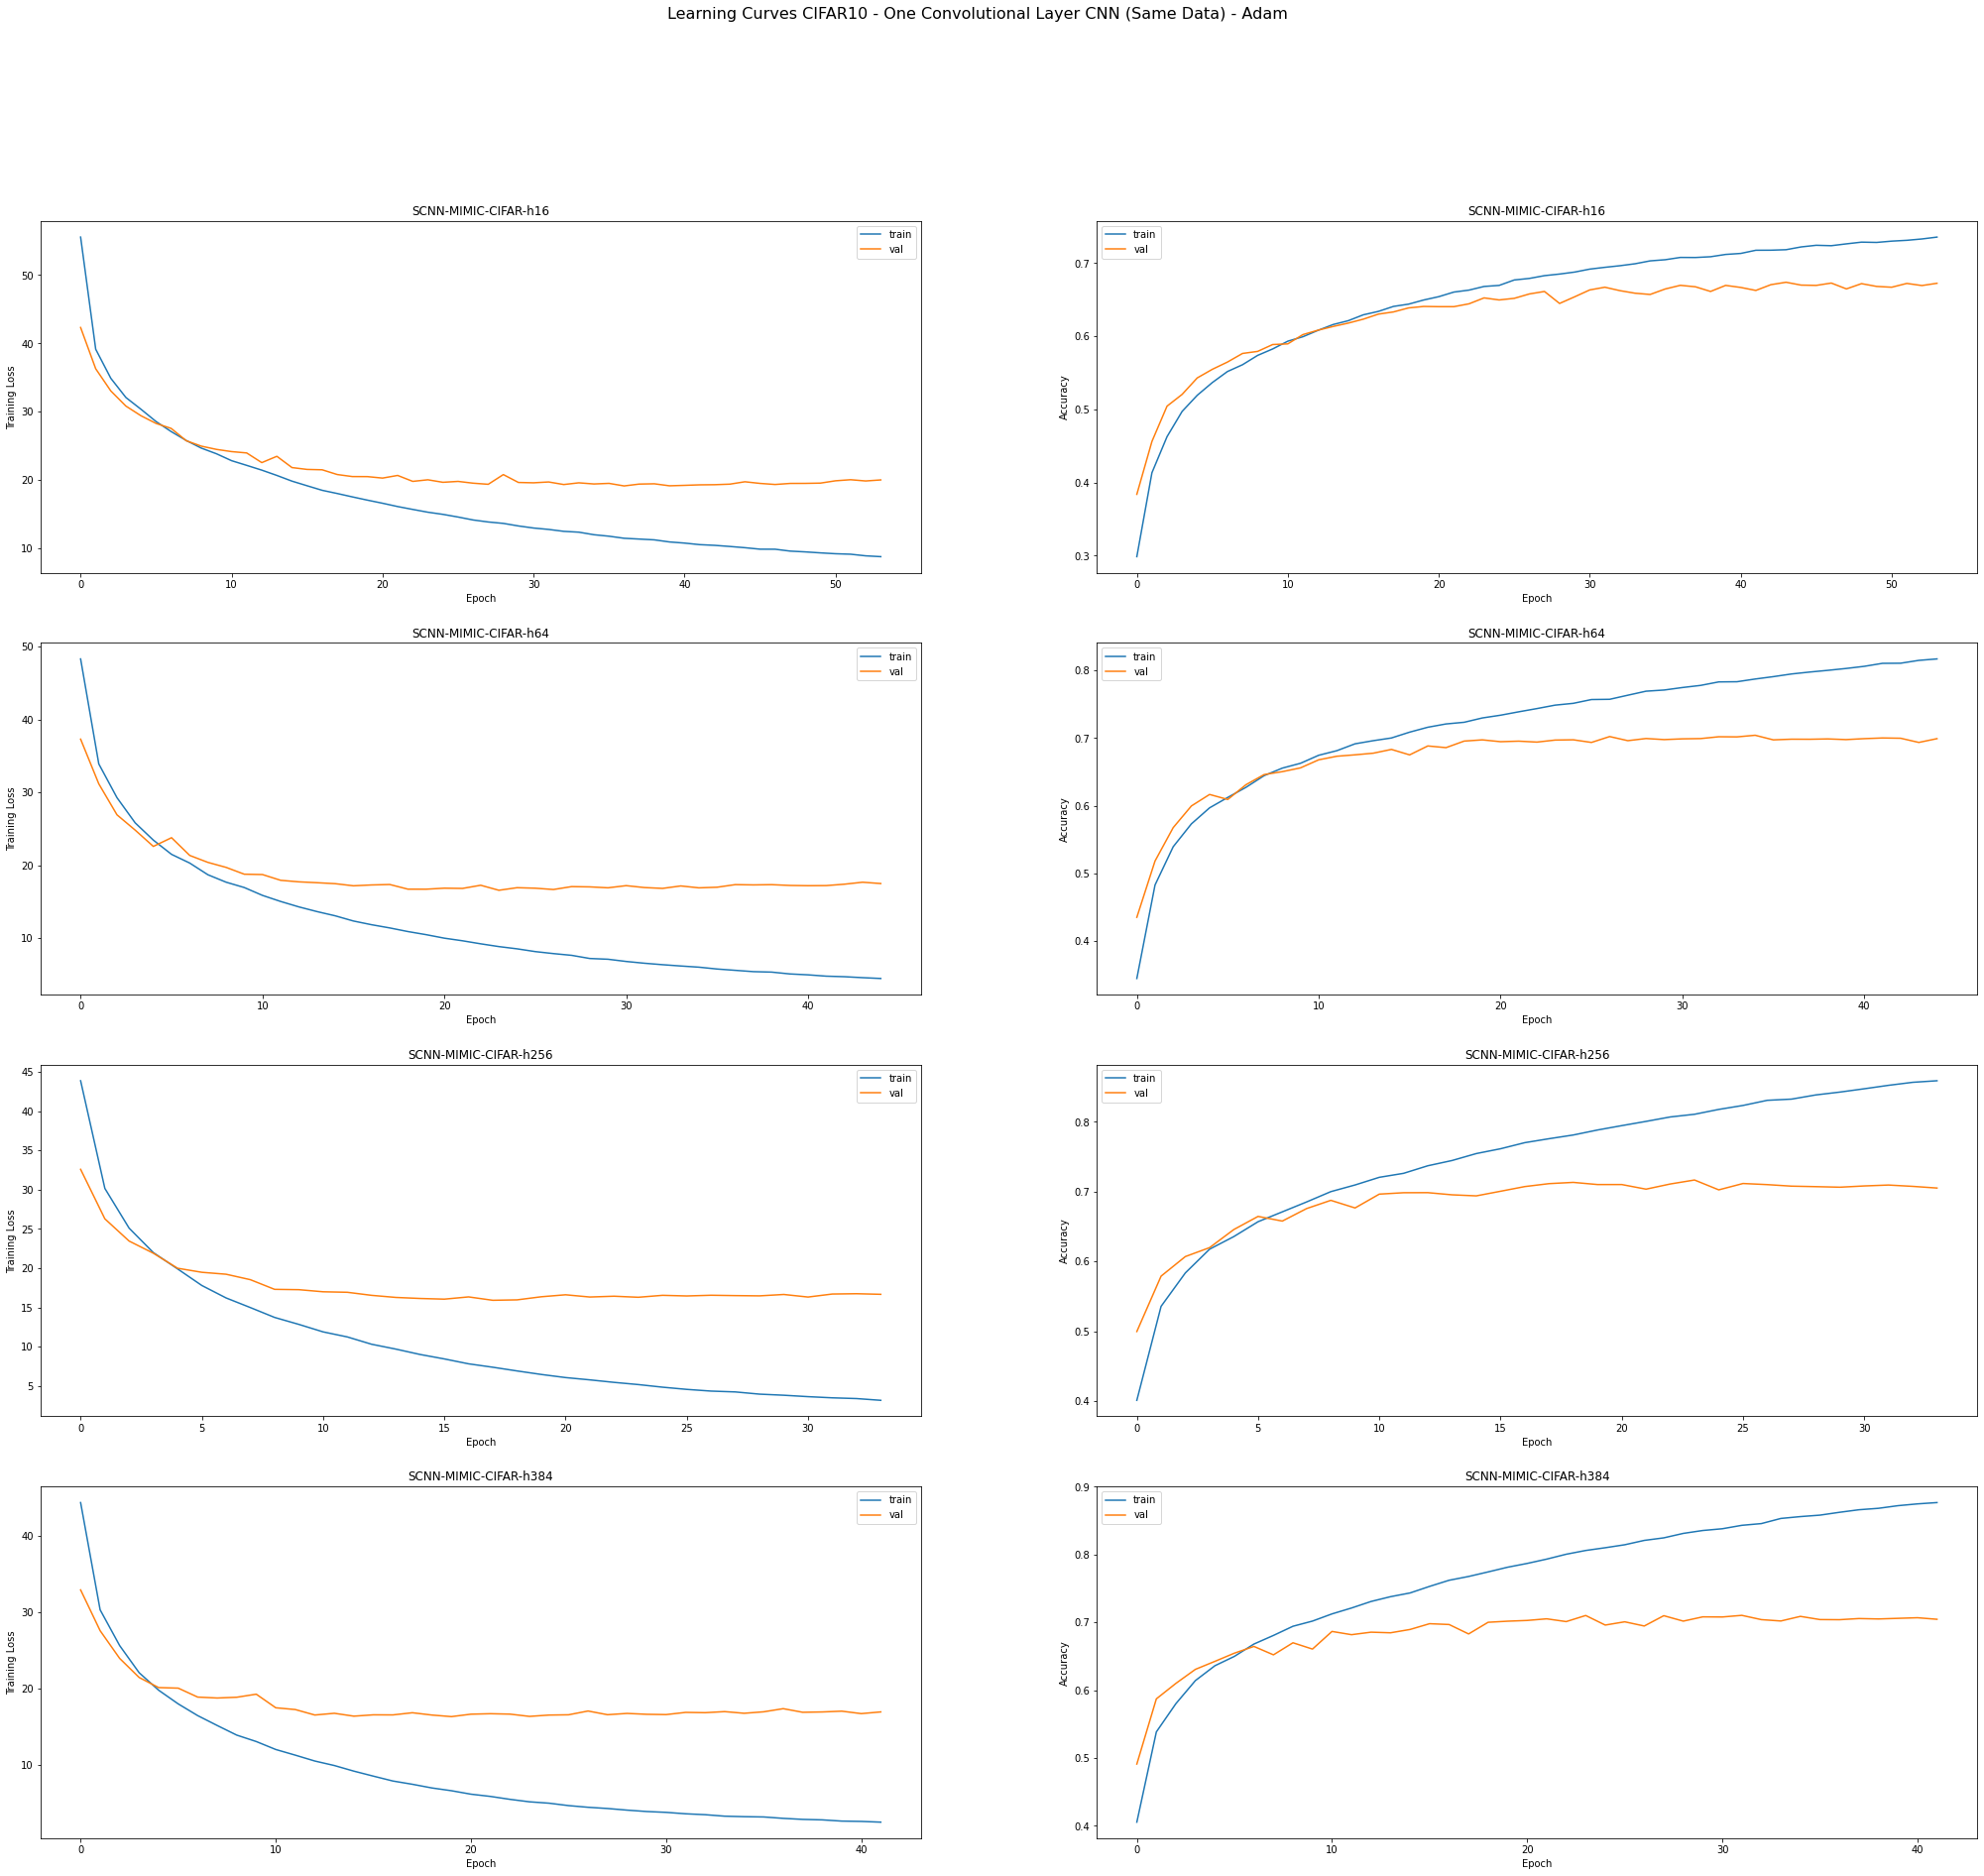

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves CIFAR10 - One Convolutional Layer CNN (Same Data) - Adam', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(4, 2, 1)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_256, label='train');
plt.plot(loss_test_256, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h256')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_256, label='train');
plt.plot(acc_test_256, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h256')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_384, label='train');
plt.plot(loss_test_384, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h384')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_384, label='train');
plt.plot(acc_test_384, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h384')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Adam


In [ ]:
loss_train_16=[31.00750604112413, 23.47555289577908, 20.531063893127442, 18.568613287353514, 17.133429162597658, 16.17126437140571, 15.32882212354872, 14.740878688218858, 14.108290957302517, 13.517378358968099, 13.200995702107747, 12.716004627143013, 12.273516659884983, 11.968001190863715, 11.614844761149088, 11.289243184746637, 11.022870464579265, 10.703815588378907, 10.45287014058431, 10.282648285251193, 9.985359819539388, 9.783219917466905, 9.62753375922309, 9.38351295369466, 9.274878630574545, 9.079764573838975, 8.937680844794379, 8.75517577633328, 8.66765478608873, 8.492214350043403, 8.33217714284261, 8.20485911356608, 8.147339184570313, 7.989515322197808, 7.952427738783094, 7.8147399893866645, 7.675418295457628, 7.5884599229600695, 7.52337034640842, 7.421299785698785]
loss_test_16 =[28.516931622314452, 22.360308044433594, 20.272024401855468, 18.632380114746095, 18.282426551818848, 16.73764529724121, 16.463086978149413, 16.07139977874756, 15.688863461303711, 15.353884283447266, 15.182306427001953, 17.005893872070313, 15.224288784790039, 15.008204089355468, 14.677745191955566, 14.160141947937012, 13.999409611511231, 13.869461862182618, 14.244486206054688, 13.780074407958985, 13.74356686706543, 13.788421719360352, 13.608251066589355, 13.654712078857422, 13.71385272216797, 13.531794836425782, 13.461428727722168, 13.738546092224121, 13.39408696899414, 13.389275390625, 13.483682061767578, 14.749448460388184, 13.498813122558595, 13.64907346496582, 13.71564267578125, 13.581179696655273, 13.53645954284668, 13.697298217773438, 13.566797973632813, 13.884003163146973]
acc_train_16 =[0.31705555, 0.4047222, 0.4419111, 0.46713334, 0.48506665, 0.49872223, 0.50825554, 0.5151778, 0.52493334, 0.53242224, 0.53456664, 0.5428889, 0.5463, 0.55002224, 0.5553333, 0.5595222, 0.562, 0.5653333, 0.5680778, 0.5694111, 0.57375556, 0.57735556, 0.57838887, 0.5801889, 0.58286667, 0.58556664, 0.58375555, 0.5874111, 0.5903111, 0.5919778, 0.5939889, 0.59544444, 0.5947111, 0.59573334, 0.5974333, 0.59954447, 0.6001667, 0.60193336, 0.6013, 0.6020778]
acc_test_16 =[0.3729499876499176, 0.4406999945640564, 0.47815001010894775, 0.4924499988555908, 0.4995500147342682, 0.5138000249862671, 0.5218999981880188, 0.5232499837875366, 0.535099983215332, 0.5376499891281128, 0.5375000238418579, 0.5142499804496765, 0.5446000099182129, 0.5511000156402588, 0.5463500022888184, 0.5590500235557556, 0.559499979019165, 0.5540500283241272, 0.5527499914169312, 0.5510500073432922, 0.5661500096321106, 0.5583999752998352, 0.5683000087738037, 0.5705500245094299, 0.569350004196167, 0.5704500079154968, 0.571399986743927, 0.5684999823570251, 0.5665500164031982, 0.5774000287055969, 0.5690500140190125, 0.5539000034332275, 0.5715500116348267, 0.5654000043869019, 0.5704500079154968, 0.5741000175476074, 0.5662999749183655, 0.5661500096321106, 0.5684999823570251, 0.567300021648407]

loss_train_64 =[27.44228129848904, 19.988783593071833, 17.10407798394097, 15.139168685574, 13.807404094187419, 12.78279482014974, 12.10701716240777, 11.29853740963406, 10.654907348971896, 10.093285335625543, 9.565084090762667, 9.082589794243706, 8.649426688639323, 8.307399998643664, 7.9286647771199545, 7.659139513481988, 7.314533037990994, 7.016458307902019, 6.7546685022989905, 6.499298874409994, 6.274064244927301, 6.049766620042589, 5.862811379072402, 5.681582625664605, 5.5129335659450955, 5.373630866071913, 5.213417418924967, 5.063435770755344, 4.9180098283555775, 4.8181524311489525, 4.679625921546088, 4.5505555499606665, 4.465438037618001, 4.3777300721486405, 4.2797399687872995, 4.155611366187202, 4.097966243235271, 4.009227276865642, 3.927060311720106, 3.870727496804131, 3.815324325942993, 3.735993822309706, 3.668720554521349]
loss_test_64 =[24.162045823669434, 23.087465130615236, 17.017298405456543, 16.300319381713866, 15.107060429382324, 14.029599925231933, 15.071686053466797, 13.608842541503906, 12.759638038635254, 12.816783267211914, 12.748298652648925, 12.085096398925781, 12.167424166870116, 12.126329338073731, 11.91431792755127, 12.094775513458252, 11.920890405273438, 12.903322051239014, 12.428200123596191, 12.122716806030274, 12.172575482940674, 12.06814796447754, 12.04478646697998, 12.336511685180664, 12.436345281982423, 12.382997286987305, 12.231937493896485, 12.899933151245117, 12.69136046142578, 12.164605671691895, 12.386921426391602, 12.365226390075684, 12.366315649414062, 12.26307776184082, 12.462339570617676, 12.865417352294921, 12.470813706970215, 12.64217028656006, 13.019169638061523, 12.62685799407959, 13.048920069885254, 13.02502015838623, 13.019778901672364]
acc_train_64 =[0.36556667, 0.46037778, 0.49684444, 0.5223, 0.5384333, 0.55237776, 0.55898887, 0.5691222, 0.5761778, 0.58385557, 0.5896111, 0.5978, 0.6024778, 0.60557777, 0.61178887, 0.61635554, 0.62137777, 0.62402225, 0.6291, 0.6327222, 0.6367667, 0.64001113, 0.64294446, 0.64687777, 0.64964443, 0.65084445, 0.6539, 0.6559778, 0.6605222, 0.6614889, 0.66473335, 0.6672889, 0.6695222, 0.67043334, 0.6724111, 0.6763667, 0.67704445, 0.68013334, 0.6809111, 0.68435556, 0.68464446, 0.6870111, 0.6889333]
acc_test_64 =[0.4372999966144562, 0.48179998993873596, 0.5278000235557556, 0.5375000238418579, 0.5464500188827515, 0.5578500032424927, 0.536050021648407, 0.5577999949455261, 0.5744500160217285, 0.57955002784729, 0.5867499709129333, 0.5948500037193298, 0.5951499938964844, 0.5863500237464905, 0.5979999899864197, 0.5971999764442444, 0.6007999777793884, 0.5928999781608582, 0.5942000150680542, 0.6011000275611877, 0.5989000201225281, 0.597000002861023, 0.5991500020027161, 0.5971500277519226, 0.5906999707221985, 0.5934000015258789, 0.5965999960899353, 0.5853999853134155, 0.5989500284194946, 0.6013500094413757, 0.5969499945640564, 0.5944499969482422, 0.6019499897956848, 0.5979499816894531, 0.5981000065803528, 0.5918499827384949, 0.5942000150680542, 0.598800003528595, 0.5934500098228455, 0.5925499796867371, 0.5917500257492065, 0.588699996471405, 0.5947999954223633]

loss_train_256 =[26.409560816786023, 18.513719474962024, 15.515619429863824, 13.874929070366754, 12.635365964084201, 11.600940288967557, 10.930716340976291, 10.116248865593803, 9.575585734388563, 8.994673973931206, 8.52006237089369, 8.001284520297581, 7.6247211861504445, 7.173743355645073, 6.864003432549371, 6.511086639065213, 6.178475978088379, 5.899964802720811, 5.683750573900011, 5.450917790476481, 5.236544582451715, 5.026210442691379, 4.847558921898736, 4.668792564137776, 4.541539272393121, 4.3809133989122175, 4.253293123287625, 4.095980339389377, 3.990498315938314, 3.895506517876519, 3.7738497888353137, 3.683610547595554, 3.583904909939236]
loss_test_256 =[23.466346362304687, 18.84742908935547, 15.295604721069337, 15.334057290649413, 13.711107551574708, 13.196319816589355, 12.657384844207764, 12.310684060668946, 12.250342782592773, 12.42060415802002, 12.268887364196777, 12.158053717041016, 12.409961216735839, 12.35719270172119, 11.943862428283692, 12.249084546661377, 12.222099259185791, 11.919900915527343, 11.884534756469726, 11.991739867401122, 12.157737341308593, 11.93756722717285, 12.128350135040284, 12.371287660980224, 12.625022101593018, 12.375676358032226, 12.214395957183838, 12.525527272033692, 12.838614715576172, 12.346196437072754, 12.942098641967773, 12.513980192565917, 12.661918147277833]
acc_train_256 =[0.37706667, 0.47893333, 0.5169778, 0.53705555, 0.5497889, 0.56424445, 0.56758887, 0.57908887, 0.5860111, 0.5918667, 0.59918886, 0.60613334, 0.6103111, 0.6192, 0.6218778, 0.62883335, 0.63457775, 0.6394111, 0.64386666, 0.6477111, 0.6517444, 0.6574778, 0.66087776, 0.6637667, 0.6671111, 0.671, 0.67455554, 0.6784667, 0.6814333, 0.6845667, 0.6885333, 0.68942225, 0.69482225]
acc_test_256 =[0.45445001125335693, 0.5080000162124634, 0.5378999710083008, 0.5327000021934509, 0.5641999840736389, 0.5720499753952026, 0.5761500000953674, 0.5860000252723694, 0.5858500003814697, 0.5803999900817871, 0.5923500061035156, 0.5885499715805054, 0.5947999954223633, 0.5925999879837036, 0.5946000218391418, 0.5949500203132629, 0.5821499824523926, 0.5918499827384949, 0.5982499718666077, 0.5946999788284302, 0.5868499875068665, 0.5958499908447266, 0.6015999913215637, 0.5894500017166138, 0.5991500020027161, 0.5910999774932861, 0.5915499925613403, 0.5934000015258789, 0.5870500206947327, 0.5959500074386597, 0.5845500230789185, 0.59375, 0.5939000248908997]

loss_train_384 =[24.924241515435114, 16.872383227539064, 14.276168968878851, 12.636056419203017, 11.407085454983182, 10.395789538913302, 9.46753599387275, 8.743392645433214, 8.044696632724339, 7.432711071438259, 6.933154574584961, 6.448732489183214, 6.040946135075887, 5.62855232916938, 5.351619765048557, 4.987203360324436, 4.737578766208225, 4.509031008063422, 4.290472090233697, 4.0917320435418025, 3.944036618381076, 3.7757042217678496, 3.592255308871799, 3.4715063677046034, 3.3446259100172253, 3.244556886015998, 3.0963362535688614]
loss_test_384 =[19.41644323425293, 16.64297947845459, 14.75274123840332, 15.87011293334961, 13.20632625656128, 12.641664079284668, 11.933533780670166, 12.38950299987793, 12.245289331054687, 11.846265979003906, 11.933517864990234, 11.797098919677735, 11.867839247131348, 11.98686629333496, 11.773786641693116, 11.870712685394286, 11.325731941986083, 11.921010617065429, 11.554644345092774, 12.053718968963622, 11.95918334350586, 11.929714826202392, 11.672057522583009, 11.897578985595704, 12.085603866577149, 11.761909399414062, 11.747030995178223]
acc_train_384 =[0.4063222, 0.5008444, 0.53256667, 0.5515556, 0.56513333, 0.5783778, 0.5910889, 0.6017778, 0.6124111, 0.6193778, 0.6260222, 0.63467777, 0.64145553, 0.64993334, 0.65473336, 0.66175556, 0.6670667, 0.6739778, 0.6793778, 0.68351114, 0.6884889, 0.6945, 0.69825554, 0.7033, 0.70724446, 0.71173334, 0.7177889]
acc_test_384 =[0.49000000953674316, 0.5174000263214111, 0.5385500192642212, 0.5511000156402588, 0.574150025844574, 0.5794000029563904, 0.5875499844551086, 0.5954499840736389, 0.583899974822998, 0.5925499796867371, 0.5977500081062317, 0.5928999781608582, 0.5960500240325928, 0.6010000109672546, 0.6049000024795532, 0.591949999332428, 0.6082000136375427, 0.6010500192642212, 0.6061000227928162, 0.5965499877929688, 0.5986999869346619, 0.5968000292778015, 0.6033999919891357, 0.6013500094413757, 0.5915499925613403, 0.595550000667572, 0.6011499762535095]


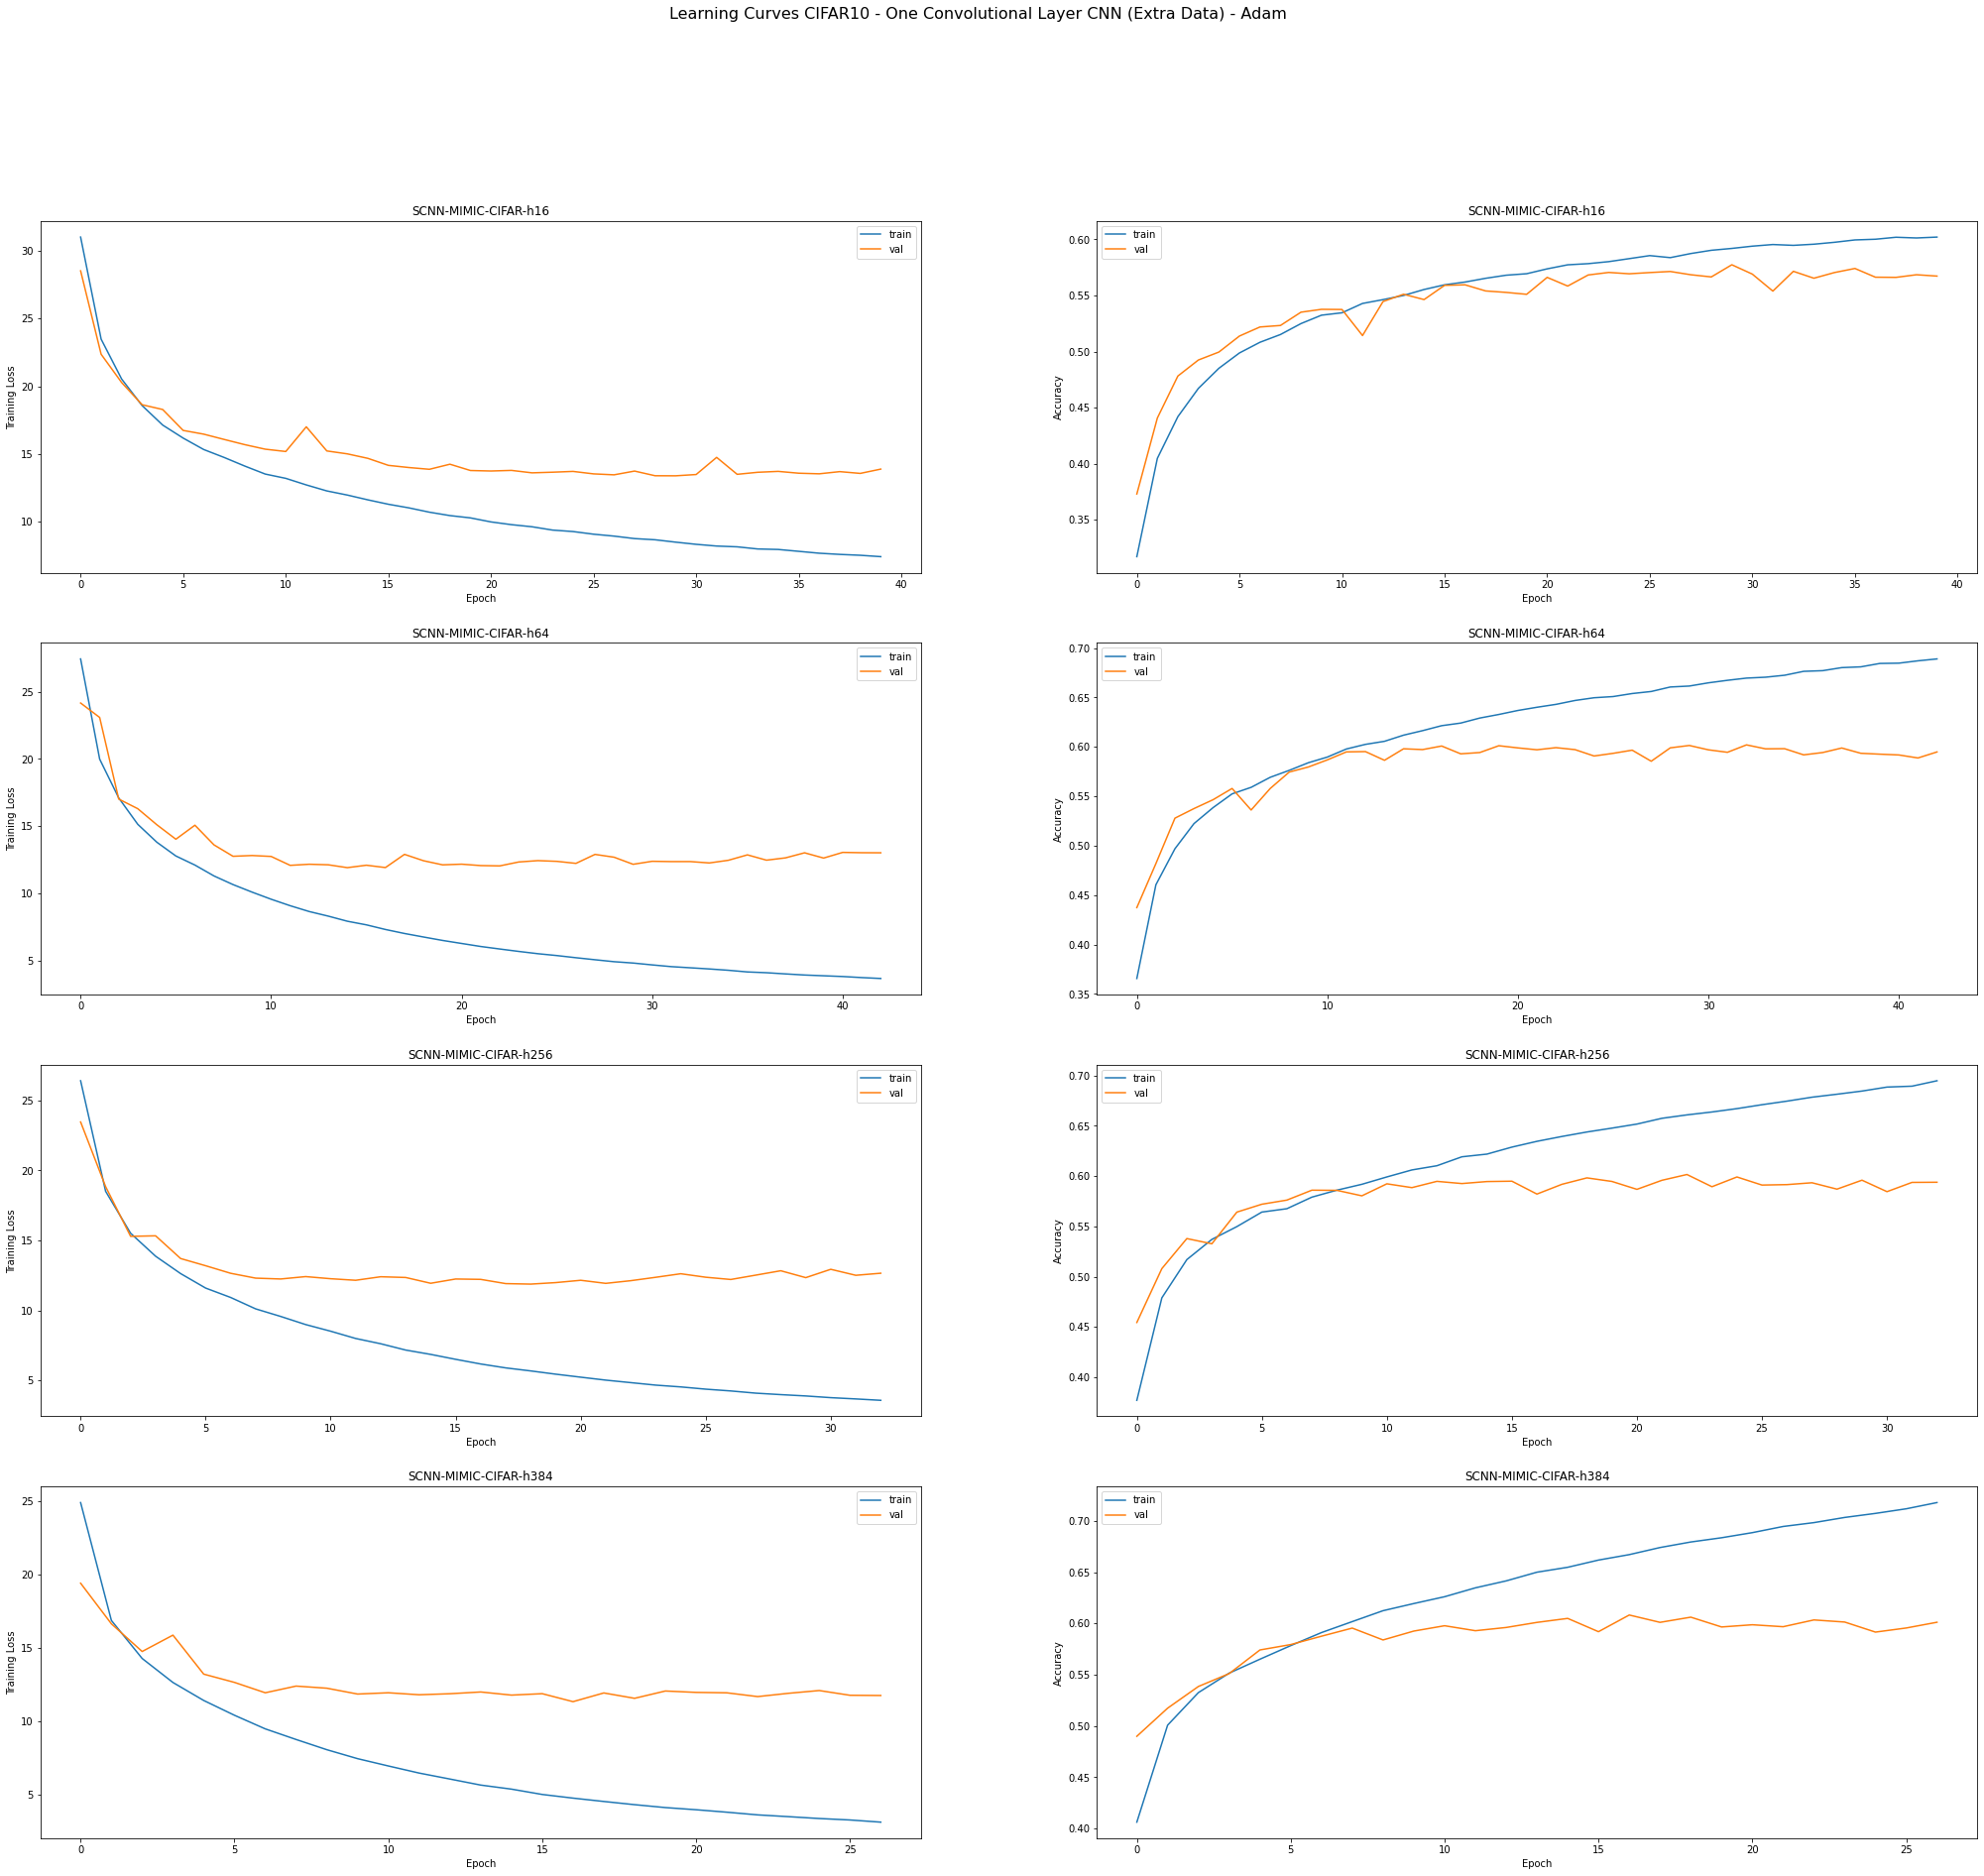

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves CIFAR10 - One Convolutional Layer CNN (Extra Data) - Adam', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(4, 2, 1)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_256, label='train');
plt.plot(loss_test_256, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h256')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_256, label='train');
plt.plot(acc_test_256, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h256')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_384, label='train');
plt.plot(loss_test_384, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h384')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_384, label='train');
plt.plot(acc_test_384, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h384')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

### Training / Evaluation for 2 Layers


#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn_extra_cifar.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn_extra_cifar.npy')

#### Training

In [ ]:
# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

channels_to_test = [64, 64, 128, 256] 
channels_to_test2 = [128, 512, 1024, 2048] 

index_for_two = 0;

for channel in channels_to_test:
  # Set name
  name = 'SCNN-CIFAR-h'+ str(index_for_two)
  cifar_model = get_CNN_model()
  cifar_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_CIFAR.h5')
  train_logits, test_logits = get_logits(cifar_model, x_train_cnn, x_test_cnn)
  cifar_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  cifar_model = adjust_model(cifar_model, name)
  cifar_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  #Save trained SNN model
  cifar_model = train_scnn(cifar_model, x_train_cnn, train_logits, x_test_cnn, test_logits)

  # Learning Curves Data
  loss_train_cnn=cifar_model.history.history['loss']
  loss_val_cnn=cifar_model.history.history['val_loss']
  acc_train_cnn=cifar_model.history.history['accuracy']
  acc_val_cnn=cifar_model.history.history['val_accuracy']

  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SCNN_MIMIC_CIFAR_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+'.h5'
  cifar_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  cifar_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  cifar_model = adjust_model(cifar_model, name)
  cifar_model = keras.models.load_model(name_to_store)

  output = cifar_model.layers[-1].output
  output = Activation('softmax')(output)
  cifar_model = Model(cifar_model.input, output, name=name)

  score = 0;
  preds = cifar_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/10000.0
  print ("Test Accuracy: %.5f" % score)
  scores_2_layer.append(score)
  channels_number.append(channel)

  index_for_two = index_for_two + 1

  import shutil
  shutil.move("/content/"+name_to_store, "/content/drive/My Drive/"+name_to_store)

  print ('----------------------------')

#### Results

##### Accuracy Results - Adam

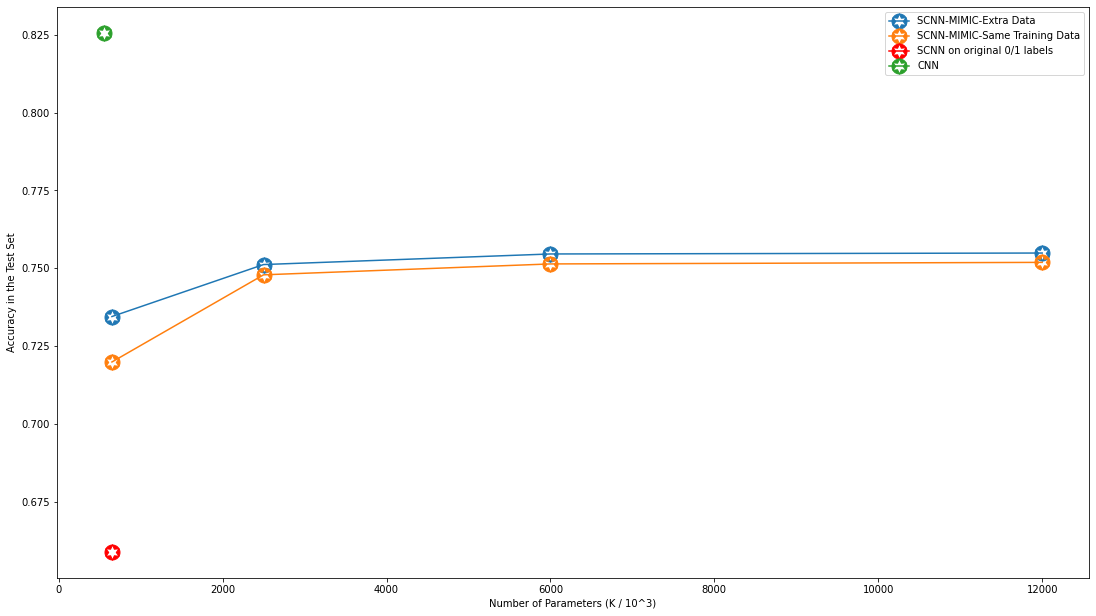

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([650, 2500, 6000, 12000 ], [0.73450, 0.75120, 0.75460, 0.75490], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([650, 2500, 6000, 12000 ], [0.71990, 0.74790, 0.75140, 0.75190], label='SCNN-MIMIC-Same Training Data', marker=cut_star, markersize=15)
plt.plot(650, 0.65890, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(550, 0.82560, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Learning Curves for Same Data - Adam

In [ ]:
loss_train_64_128 =[50.331728302001956, 34.67408419799805, 28.935358941650392, 25.118713671875, 22.246975149536134, 19.912196774291992, 18.205214834594727, 16.788453408813478, 15.639945095825196, 14.603447395324707, 13.426023320007324, 12.722922483825684, 12.09110744934082, 11.446275329589843, 10.825552258300782, 10.25266172027588, 9.728896771240235, 9.384397093200684, 8.928455464172364, 8.493888356781007, 8.273288550567626, 7.8345481903076175, 7.561355252838135, 7.296375148010254, 7.036854566955566, 6.850410397338867, 6.606453744506836, 6.367906252288819, 6.128509191894532, 5.925737145233154, 5.759263692474366, 5.548215773010254, 5.491652261352539, 5.247227146911621, 5.103271762084961, 5.037880383300781, 4.818158916473388, 4.71700005493164, 4.574308276367187, 4.532179688262939, 4.3814606185913085, 4.261048506164551, 4.172305175018311, 4.0753532363891605, 3.968334019470215, 3.9760182666778565, 3.8392719696044924, 3.75708731880188, 3.7366358921051024, 3.6387277782440184, 3.5403306903839113, 3.4988257453918457, 3.445525001144409, 3.3913716835021974, 3.2993857887268065, 3.297802109527588, 3.2004761367797854, 3.1962667339324953, 3.1718204360961915, 3.105193462371826, 3.0222763557434082, 2.9767276710510253, 2.973767373275757, 2.92000343170166, 2.8797392971038818, 2.8447493980407716, 2.8053177574157715, 2.785653266143799, 2.7079083084106443, 2.723619186782837, 2.745117687988281, 2.6763533668518065]
loss_test_64_128 =[39.04786015625, 30.442838973999024, 25.486042724609376, 22.786106823730467, 20.702603642272948, 19.007612677001955, 17.378095440673828, 17.930516917419432, 16.302580809020995, 15.082254895019531, 14.55938689880371, 14.313670361328125, 14.121429080200196, 13.43051629333496, 13.349476286315918, 13.223069296264649, 12.327937602233886, 12.300463311767578, 12.059146432495117, 12.355640908813477, 11.932360559082031, 11.849673013305663, 12.16884300994873, 11.620049801635743, 12.752341635894775, 11.956896406555176, 11.967491519165039, 11.903188233947754, 11.602706733703613, 11.68354525756836, 11.836809324645996, 11.894263272094726, 11.828023559570312, 12.111498533630371, 11.908880122375487, 11.842548553466797, 12.111084413146973, 12.32026576461792, 12.061948475646973, 11.959521920776368, 11.91338103942871, 12.718187091064452, 12.01357915802002, 12.089985166168212, 12.189106137084961, 12.45906524810791, 12.211280358886718, 12.499946562194824, 13.001337998962402, 12.211828903198242, 12.496700546264648, 12.42593816986084, 12.644018377685548, 12.363788542175293, 12.759424537658692, 12.61461682434082, 12.493055673217773, 12.587790570068359, 12.870289297485352, 12.755282440185546, 12.734668737792969, 12.760063973999024, 12.76836775817871, 12.73184802093506, 12.95466124420166, 12.74375756225586, 12.81337612915039, 12.791531047058106, 12.914381315612793, 12.990996139526366, 13.323486041259766, 12.922673936462402]
acc_train_64_128 =[0.327175, 0.46465, 0.5252, 0.565725, 0.59415, 0.6202, 0.641225, 0.6567, 0.66925, 0.6815, 0.6944, 0.7043, 0.710775, 0.721475, 0.73005, 0.736, 0.7424, 0.7465, 0.7549, 0.760325, 0.76525, 0.7688, 0.77545, 0.777425, 0.782775, 0.78665, 0.78975, 0.791375, 0.7976, 0.7988, 0.801675, 0.80465, 0.806975, 0.809325, 0.8114, 0.812925, 0.816325, 0.818375, 0.822375, 0.82125, 0.8237, 0.827375, 0.829775, 0.830275, 0.83235, 0.831775, 0.8375, 0.836425, 0.8389, 0.839925, 0.841925, 0.842, 0.844475, 0.84525, 0.8468, 0.847875, 0.849375, 0.8495, 0.8523, 0.85235, 0.8539, 0.856075, 0.8548, 0.8579, 0.857725, 0.85915, 0.859575, 0.860775, 0.862825, 0.861375, 0.862175, 0.8645]
acc_test_64_128 =[0.4187000095844269, 0.4932999908924103, 0.5679000020027161, 0.5978000164031982, 0.6208000183105469, 0.6491000056266785, 0.659600019454956, 0.6625999808311462, 0.6674000024795532, 0.698199987411499, 0.7089999914169312, 0.6948999762535095, 0.7120000123977661, 0.714900016784668, 0.7174000144004822, 0.7287999987602234, 0.7335000038146973, 0.736299991607666, 0.7462999820709229, 0.7384999990463257, 0.7465999722480774, 0.7537999749183655, 0.7477999925613403, 0.7516000270843506, 0.739799976348877, 0.7523999810218811, 0.7516000270843506, 0.7486000061035156, 0.7552000284194946, 0.756600022315979, 0.7558000087738037, 0.7587000131607056, 0.7537999749183655, 0.7585999965667725, 0.7559000253677368, 0.7560999989509583, 0.7505000233650208, 0.7592999935150146, 0.7556999921798706, 0.7587000131607056, 0.758899986743927, 0.754800021648407, 0.7588000297546387, 0.7588000297546387, 0.7597000002861023, 0.7598000168800354, 0.7595999836921692, 0.7538999915122986, 0.7555000185966492, 0.7621999979019165, 0.7609999775886536, 0.7638000249862671, 0.7613000273704529, 0.7573000192642212, 0.7602999806404114, 0.7551000118255615, 0.7638000249862671, 0.7623999714851379, 0.7585999965667725, 0.7584999799728394, 0.761900007724762, 0.7641000151634216, 0.762499988079071, 0.7583000063896179, 0.756600022315979, 0.7578999996185303, 0.7592999935150146, 0.7565000057220459, 0.7544999718666077, 0.7549999952316284, 0.7541000247001648, 0.7565000057220459]

loss_train_64_512 =[47.022609448242186, 30.81446986694336, 24.779748507690428, 21.307643518066406, 18.455024227905273, 16.366161920166014, 14.811457592773438, 13.545079739379883, 12.273052447509766, 11.396993273925782, 10.407988385009766, 9.547561962890626, 8.939509622192382, 8.2799587890625, 7.8000520301818845, 7.129704849243164, 6.63194695892334, 6.232518857574463, 5.799878816223145, 5.451336917877197, 5.0021408203125, 4.6852010841369625, 4.492568775177002, 4.183876058197021, 3.9425782470703123, 3.7568544342041017, 3.559870757293701, 3.333083080291748, 3.1595885540008544, 3.071715472793579, 2.868299713897705, 2.799622978973389, 2.639135657119751, 2.5756155639648437, 2.537743883895874, 2.388761840057373, 2.263647219848633, 2.277853573989868, 2.223551537322998, 2.1028239685058594, 2.013535920715332, 1.9433447187423707]
loss_test_64_512 =[34.35796396484375, 25.789031121826174, 21.858085681152343, 19.284112182617186, 17.894831509399413, 15.995314317321778, 15.000623202514648, 14.54171533203125, 13.856105041503906, 14.216278048706055, 12.446957537841797, 12.688937030029297, 11.882942028808595, 12.546053518676757, 11.849772378540038, 11.164816108703613, 11.854663537597656, 11.352268435668945, 11.170334088134766, 11.02617724456787, 11.167089282226563, 11.215695390319825, 11.329682759094238, 10.99619482421875, 11.198853425598145, 10.936077989196777, 11.333186528015137, 11.154260919189452, 11.589573738098144, 11.471721813964844, 11.223468751525878, 11.230042964172362, 11.238454986572266, 11.2738148727417, 11.477732040405273, 11.173470060729981, 11.619550869750977, 11.455940869140624, 11.543483311462403, 11.388904455566406, 11.547177926635742, 11.5042989944458]
acc_train_64_512 =[0.3612, 0.507575, 0.578725, 0.6167, 0.64585, 0.668425, 0.683375, 0.70055, 0.714225, 0.724675, 0.738125, 0.751925, 0.760025, 0.7708, 0.776125, 0.7879, 0.79555, 0.80085, 0.81005, 0.816625, 0.822425, 0.827025, 0.833, 0.838075, 0.84425, 0.84795, 0.853275, 0.8573, 0.8592, 0.864625, 0.8675, 0.8707, 0.874225, 0.877775, 0.8806, 0.88435, 0.88635, 0.886975, 0.88965, 0.892175, 0.894525, 0.89655]
acc_test_64_512 =[0.4650000035762787, 0.564300000667572, 0.6222000122070312, 0.6543999910354614, 0.6710000038146973, 0.6934999823570251, 0.6930000185966492, 0.6980000138282776, 0.7175999879837036, 0.7175999879837036, 0.7337999939918518, 0.7328000068664551, 0.7459999918937683, 0.7505000233650208, 0.7519999742507935, 0.7638000249862671, 0.7587000131607056, 0.7613999843597412, 0.7694000005722046, 0.7717000246047974, 0.7728000283241272, 0.7702000141143799, 0.777999997138977, 0.7742999792098999, 0.7806000113487244, 0.7789000272750854, 0.7764000296592712, 0.7753999829292297, 0.7789000272750854, 0.7760999798774719, 0.7785000205039978, 0.7835000157356262, 0.7800999879837036, 0.7735000252723694, 0.7799000144004822, 0.7803000211715698, 0.7735999822616577, 0.7770000100135803, 0.7770000100135803, 0.7766000032424927, 0.7767999768257141, 0.7806000113487244]

loss_train_128_1024 =[43.707562219238284, 26.917665060424806, 20.966654907226562, 17.56267699432373, 14.970504943847656, 13.275522396850587, 11.740599606323242, 10.499848669433593, 9.431741804504394, 8.502686555480958, 7.937106733703613, 7.0781427619934085, 6.353653500366211, 5.799643524932861, 5.212051940917969, 4.8576673362731935, 4.351300870513916, 4.0711262351989745, 3.669755056381226, 3.4172307075500488, 3.279010732269287, 3.026293098449707, 2.803018508911133, 2.6587442008972166, 2.5143699375152586, 2.31859988861084, 2.239381238555908, 2.205472462081909, 2.1070162452697754]
loss_test_128_1024=[31.64680344238281, 23.569074145507813, 19.380104727172853, 17.38525723876953, 15.50070538635254, 13.462804200744628, 12.579778717041016, 12.575826928710937, 11.443134329223632, 12.119399957275391, 10.932540914916991, 11.21286773223877, 10.638608407592773, 10.427910021972655, 10.562438586425781, 10.870319541931153, 10.663579780578614, 10.22016315612793, 10.173087646484374, 10.262679010009766, 10.988952688598634, 10.342452680969238, 10.32697946472168, 10.391434939575195, 10.688482926940917, 10.816296206665038, 10.498397357177735, 10.695327502441407, 10.882251742553711]
acc_train_128_1024 =[0.38665, 0.55085, 0.613625, 0.6482, 0.680075, 0.705275, 0.724275, 0.74025, 0.755075, 0.76795, 0.777575, 0.789025, 0.799225, 0.809, 0.8177, 0.82435, 0.83305, 0.83915, 0.8477, 0.854175, 0.8582, 0.86315, 0.8705, 0.8753, 0.878775, 0.883925, 0.88765, 0.89115, 0.8926]
acc_test_128_1024 =[0.5051000118255615, 0.5871000289916992, 0.6528000235557556, 0.6858000159263611, 0.6888999938964844, 0.7228000164031982, 0.7210000157356262, 0.7351999878883362, 0.744700014591217, 0.7506999969482422, 0.7662000060081482, 0.7627000212669373, 0.7706000208854675, 0.7692999839782715, 0.7802000045776367, 0.7768999934196472, 0.7799000144004822, 0.7870000004768372, 0.7903000116348267, 0.7821999788284302, 0.7900000214576721, 0.7843000292778015, 0.7868000268936157, 0.7864000201225281, 0.7842000126838684, 0.7835000157356262, 0.7853999733924866, 0.7874000072479248, 0.7836999893188477]

loss_train_256_2048 =[41.15408009338379, 24.226148809814454, 18.713964929199218, 15.33904680633545, 13.216741680908203, 11.538373712158203, 10.150885091400147, 8.760449464416505, 7.807059800720215, 6.925174565124512, 5.982501624298096, 5.391915653991699, 4.742855372619629, 4.214022837066651, 3.851464360046387, 3.3993355766296385, 3.0942377113342285, 2.8520414436340333, 2.6542987991333007, 2.4026834991455077, 2.2822983947753905, 2.1756894832611082, 2.11395070476532, 1.849404174041748, 1.7830647682189942, 1.8249784114837646, 1.694617947769165, 1.51842242603302, 1.474012525177002, 1.462762970352173, 1.4155954774856567]
loss_test_256_2048 =[26.799265829467775, 19.330237704467773, 16.590389826965332, 14.70580759124756, 13.928860809326173, 13.34011357421875, 12.612188171386718, 11.275136811828613, 12.125136305236817, 10.521214529418945, 10.39032861328125, 10.068321200561524, 10.007525527954101, 10.018474909973145, 10.026849197387696, 10.476392503356934, 10.012833047485351, 10.129816772460938, 10.058716586303712, 9.88083600616455, 9.946299856567382, 10.035688679504394, 9.883703628540038, 9.932088986206054, 9.97517763671875, 10.09561120376587, 10.028774871826172, 9.963062545013427, 10.250363603210449, 10.006739684295654, 10.086715249633789]
acc_train_256_2048 =[0.414675, 0.5798, 0.639525, 0.681, 0.7061, 0.728775, 0.74815, 0.764925, 0.7832, 0.79445, 0.809175, 0.8177, 0.83045, 0.84095, 0.848525, 0.85815, 0.866, 0.8715, 0.8779, 0.886275, 0.890875, 0.89655, 0.89935, 0.9058, 0.908875, 0.911075, 0.915225, 0.92005, 0.92265, 0.924, 0.92605]
acc_test_256_2048 =[0.5713000297546387, 0.6417999863624573, 0.6747000217437744, 0.7042999863624573, 0.7129999995231628, 0.7366999983787537, 0.7457000017166138, 0.7538999915122986, 0.7595999836921692, 0.7748000025749207, 0.7746999859809875, 0.7886999845504761, 0.7820000052452087, 0.7900000214576721, 0.7901999950408936, 0.7864000201225281, 0.7983999848365784, 0.7928000092506409, 0.795199990272522, 0.7989000082015991, 0.8004000186920166, 0.7985000014305115, 0.7950999736785889, 0.7990000247955322, 0.7957000136375427, 0.7962999939918518, 0.796500027179718, 0.7972000241279602, 0.7955999970436096, 0.7975000143051147, 0.7955999970436096]


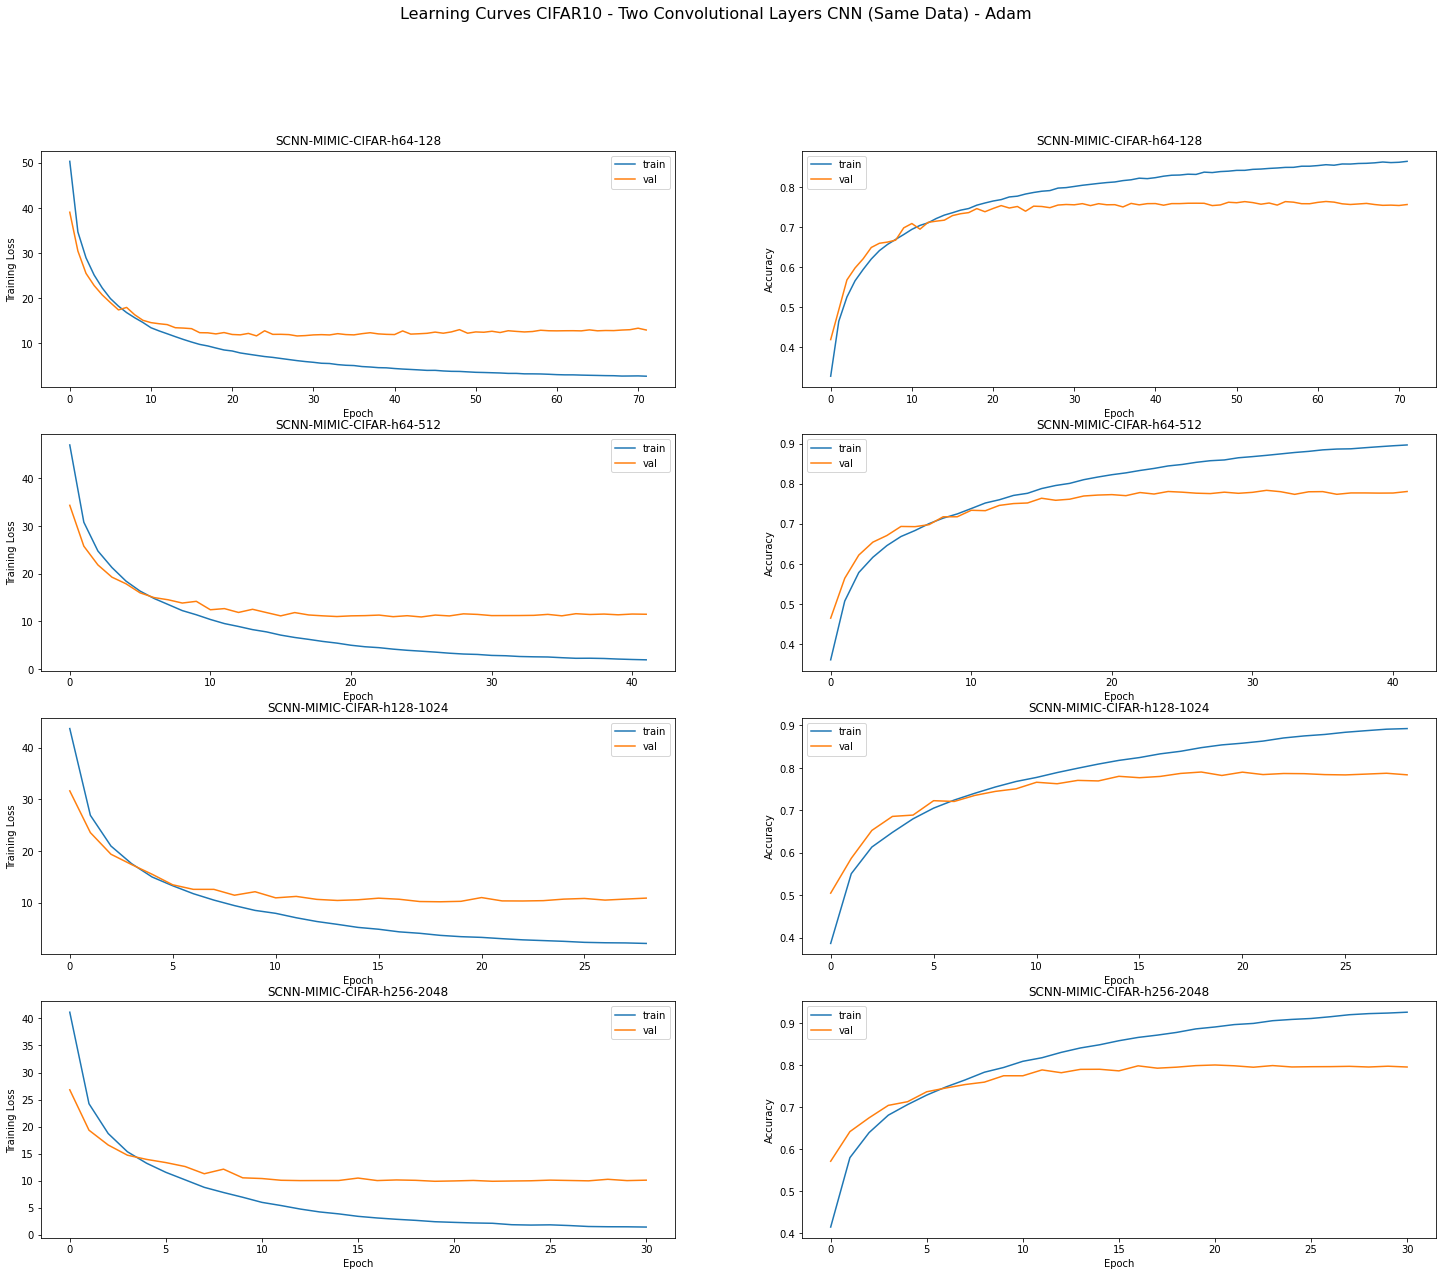

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves CIFAR10 - Two Convolutional Layers CNN (Same Data) - Adam', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_128_1024, label='train');
plt.plot(loss_test_128_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h128-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_128_1024, label='train');
plt.plot(acc_test_128_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h128-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_256_2048, label='train');
plt.plot(loss_test_256_2048, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h256-2048')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_256_2048, label='train');
plt.plot(acc_test_256_2048, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h256-2048')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Adam

In [ ]:
loss_train_64_128 =[28.259908656141494, 18.654582946099175, 15.501009148491754, 13.412403783501519, 11.974843487209744, 10.722758121914334, 9.92279515109592, 9.093907335238987, 8.590644176567926, 7.997194606865777, 7.564122852918837, 7.187558299509684, 6.849119947306315, 6.564698697408041, 6.316553469424777, 6.089802169630262, 5.87080943154229, 5.698960530768501, 5.464960370466444, 5.295193166944716, 5.2001242925008135, 5.047424995252821, 4.9101833468967016, 4.795506703016493, 4.699998980882433, 4.567475540033977, 4.455316661241319, 4.38428588104248, 4.271024760013156, 4.186249323103163, 4.1131031282213, 4.066142108620538, 3.947426730261909, 3.932160498046875, 3.830136728922526, 3.79555171424018, 3.7314032870822484, 3.6879151458740234, 3.6204624467637805, 3.598095290459527, 3.518546196068658, 3.4922526885138616, 3.4470496802012125, 3.403190121290419, 3.3589935134887696, 3.33104105919732]
loss_test_64_128 =[21.712210385131836, 17.183315505981444, 15.050016702270508, 12.972708613586425, 12.78128526916504, 11.413134294128419, 10.621354763793946, 10.730891202545166, 9.71402774963379, 9.571941757965089, 10.017608229064942, 8.960962990570069, 8.8285100730896, 8.498091313934326, 8.761288020324708, 8.701642176818847, 8.866614347839356, 9.037179331970215, 8.35400266494751, 8.30019945602417, 8.616803658294678, 8.441892933654785, 8.464534223937989, 8.723410298156738, 8.700210342407226, 8.392418737792969, 8.49221162109375, 8.520431694030762, 8.452593199157715, 8.37721202545166, 8.5742185546875, 8.318894213104247, 9.053460918426513, 8.676589971160888, 8.603299116516114, 8.68747836303711, 8.695560617828368, 8.640606875610352, 8.620335285949707, 8.71176902770996, 8.799586819458009, 8.688742115783691, 8.817815739440919, 8.878408603668213, 8.889959913635254, 8.787610920715332]
acc_train_64_128 =[0.3552, 0.47133332, 0.5149222, 0.54345554, 0.5647778, 0.58221114, 0.59657776, 0.6099, 0.61612225, 0.6257667, 0.63582224, 0.6407889, 0.64556664, 0.65261114, 0.6565, 0.6596889, 0.6642111, 0.6652667, 0.6695, 0.6723667, 0.6754444, 0.6783556, 0.67896664, 0.6807889, 0.68218887, 0.6859222, 0.6860222, 0.6895, 0.69004446, 0.6923, 0.69247776, 0.6959, 0.6975333, 0.6979778, 0.70214444, 0.69916666, 0.7020222, 0.70118886, 0.70493335, 0.7050111, 0.70816666, 0.7069333, 0.70842224, 0.7095889, 0.71183336, 0.7126667]
acc_test_64_128 =[0.4492500126361847, 0.5078499913215637, 0.5474500060081482, 0.5756499767303467, 0.5731499791145325, 0.5954999923706055, 0.6132500171661377, 0.6179999709129333, 0.6244000196456909, 0.6291499733924866, 0.6178500056266785, 0.6432499885559082, 0.6509000062942505, 0.6478999853134155, 0.6484500169754028, 0.6511499881744385, 0.6384999752044678, 0.6534000039100647, 0.656000018119812, 0.6521999835968018, 0.6563500165939331, 0.6556500196456909, 0.6567500233650208, 0.6510499715805054, 0.657800018787384, 0.6567500233650208, 0.6539499759674072, 0.6538000106811523, 0.6570500135421753, 0.6576499938964844, 0.6585500240325928, 0.6576499938964844, 0.6520500183105469, 0.6600499749183655, 0.6603000164031982, 0.6642000079154968, 0.6611999869346619, 0.661899983882904, 0.6614000201225281, 0.6593999862670898, 0.6601499915122986, 0.661549985408783, 0.6554999947547913, 0.6592000126838684, 0.6589499711990356, 0.6588500142097473]

loss_train_64_512 =[25.75581545850966, 15.717356225585938, 12.530220776960585, 10.566573097059463, 9.15000620795356, 8.111093845621745, 7.297796777174208, 6.642670319620768, 6.00790610148112, 5.515434332529704, 5.1130852294074165, 4.725623399353028, 4.344684525044759, 4.067718258243137, 3.8020968066745335, 3.6121383952246773, 3.371596268632677, 3.208930569797092, 3.01808766623603, 2.8616043065389, 2.7416423799302843, 2.644328727976481, 2.5618213291168215, 2.449430135260688, 2.3364855578104655, 2.2805190861596003, 2.2157216478559705, 2.1381960981580947, 2.0558850964864095, 2.063693390909831]
loss_test_64_512 =[18.96155951843262, 15.208056650543213, 12.624435241699219, 10.516258618164063, 10.614221161651612, 8.758829957580566, 9.228688200378418, 8.627425668334961, 8.200005818939209, 8.338705168914794, 7.67424986114502, 7.630752677154541, 7.787556633758545, 7.665135484313965, 8.506001934814453, 8.102208233642578, 7.63049161529541, 7.686483605957031, 7.702172850036621, 7.665427651977539, 7.848407907867432, 7.859448895263672, 7.7880555969238285, 8.558050859069825, 7.774340171813964, 8.010991172790527, 8.041432585144044, 7.964370267486572, 7.911213688659668, 8.061758613586425]
acc_train_64_512 =[0.3836889, 0.51427776, 0.55876666, 0.5875222, 0.61083335, 0.63034445, 0.6444333, 0.6561222, 0.66535556, 0.6776889, 0.6861, 0.69112223, 0.7009111, 0.70676666, 0.71302223, 0.71735555, 0.7242111, 0.72797775, 0.73032224, 0.7362555, 0.74016666, 0.7438, 0.7459555, 0.7499222, 0.75417775, 0.7549222, 0.76066667, 0.76154447, 0.76618886, 0.76703334]
acc_test_64_512 =[0.48464998602867126, 0.5467000007629395, 0.5766500234603882, 0.6065000295639038, 0.6081500053405762, 0.6468499898910522, 0.6380000114440918, 0.6570000052452087, 0.665149986743927, 0.663349986076355, 0.6747499704360962, 0.6789000034332275, 0.6728000044822693, 0.6786500215530396, 0.671750009059906, 0.670199990272522, 0.6799499988555908, 0.6798999905586243, 0.6769000291824341, 0.6833500266075134, 0.6795499920845032, 0.6764500141143799, 0.680400013923645, 0.6747999787330627, 0.6776999831199646, 0.677299976348877, 0.6748499870300293, 0.6750500202178955, 0.6754000186920166, 0.675000011920929]

loss_train_128_1024 =[25.86786818678114, 15.78586630045573, 12.261247418806288, 10.250218007405598, 8.876770606825087, 7.929413758171929, 7.141781645372179, 6.471430203925239, 5.94388312242296, 5.4589679814656575, 5.079755775960287, 4.7315233556111655, 4.401633954366048, 4.114737284342448, 3.9115099017673067, 3.6772650859408906, 3.4788628000047472, 3.3482733055114746, 3.2003267245822484, 3.0474359149509005, 2.9217668073442247, 2.8224921488867865, 2.7271576716105144, 2.6609887231614855, 2.5796059950086807, 2.506605190234714, 2.413212535603841, 2.3543105384402807, 2.310411280737983, 2.2481014195336235, 2.1963490697224937]
loss_test_128_1024=[18.059555584716797, 13.745680624389648, 11.188827617645263, 10.434559387207031, 9.534530432128907, 9.140577891540527, 8.562798924255372, 8.009123682403564, 7.961744290924072, 7.959991487121582, 7.773288876342773, 8.367118005371093, 7.690165300750732, 7.539518980407715, 7.941390847015381, 7.753565428161621, 7.7538246932983395, 7.731349594116211, 7.884452247619629, 7.6360005958557124, 7.682531495666504, 7.699616578674316, 7.9052762580871585, 7.865550086975098, 8.068276234436036, 7.771300804901123, 7.805277102661133, 8.014772240447998, 7.977737789154053, 8.07783900680542, 7.986518127441406]
acc_train_128_1024 =[0.38043332, 0.50872225, 0.55984443, 0.5922111, 0.6142333, 0.63115555, 0.6474778, 0.6585, 0.66796666, 0.6774222, 0.68293333, 0.6919889, 0.6974111, 0.70294446, 0.70894444, 0.71346664, 0.71673334, 0.7208, 0.7256778, 0.7298, 0.73304445, 0.7353, 0.7394222, 0.74043334, 0.74384445, 0.7459555, 0.74855554, 0.75225556, 0.7539222, 0.7578667, 0.7582778]
acc_test_128_1024 =[0.49889999628067017, 0.5641499757766724, 0.5968499779701233, 0.6135500073432922, 0.6283000111579895, 0.6406499743461609, 0.6492499709129333, 0.6593000292778015, 0.664900004863739, 0.6699000000953674, 0.6740999817848206, 0.6660000085830688, 0.6772500276565552, 0.6780499815940857, 0.6741499900817871, 0.6663500070571899, 0.6686999797821045, 0.6798999905586243, 0.6804999709129333, 0.6811000108718872, 0.6827999949455261, 0.6802499890327454, 0.6809499859809875, 0.6823999881744385, 0.6702499985694885, 0.677049994468689, 0.6783999800682068, 0.6796000003814697, 0.6734499931335449, 0.6751499772071838, 0.6765999794006348]

loss_train_256_2048 =[25.61176105041504, 15.617553528849283, 12.093391292317708, 9.91162258758545, 8.557412434471978, 7.625130224100749, 6.864100822618273, 6.228437366400825, 5.780450040011936, 5.278459594302707, 4.921430509270562, 4.5867454573313395, 4.386839559851753, 4.114510101233589, 3.829508876715766, 3.678206248304579, 3.5083735418107773, 3.319267560619778, 3.2043225279490155, 3.0675137142181397, 2.978529612223307, 2.86677883928087, 2.7621261738671197, 2.6747210873497855]
loss_test_256_2048 =[19.023444961547852, 14.115762942504883, 12.026041482543945, 10.329548641967774, 9.116478869628907, 8.467233554077149, 8.040942570495606, 8.246427737426758, 8.154255643463134, 7.86755122833252, 8.307127273559571, 7.723450575256348, 7.5552177917480465, 7.397113777923584, 7.781477853393555, 7.6652033920288085, 7.4736258430480955, 7.715136112976074, 7.774320371246338, 7.604067315673828, 7.808773921203613, 7.731228193664551, 7.684039794921875, 7.7755121284484865]
acc_train_256_2048 =[0.38785556, 0.51445556, 0.5636778, 0.59735554, 0.6205222, 0.63725555, 0.65022224, 0.6636, 0.6707889, 0.6808444, 0.68754447, 0.69443333, 0.69916666, 0.7040778, 0.7094333, 0.7135222, 0.7177, 0.7236111, 0.72583336, 0.7302778, 0.7322111, 0.73513335, 0.7408, 0.74241114]
acc_test_256_2048 =[0.4826500117778778, 0.5579500198364258, 0.5905500054359436, 0.6055999994277954, 0.6362000107765198, 0.6481500267982483, 0.6610999703407288, 0.6551499962806702, 0.66839998960495, 0.6692000031471252, 0.6697499752044678, 0.6692500114440918, 0.6797999739646912, 0.6852499842643738, 0.6803500056266785, 0.6754000186920166, 0.6843000054359436, 0.6851999759674072, 0.6828500032424927, 0.6837000250816345, 0.6811000108718872, 0.6802499890327454, 0.680400013923645, 0.6801000237464905]


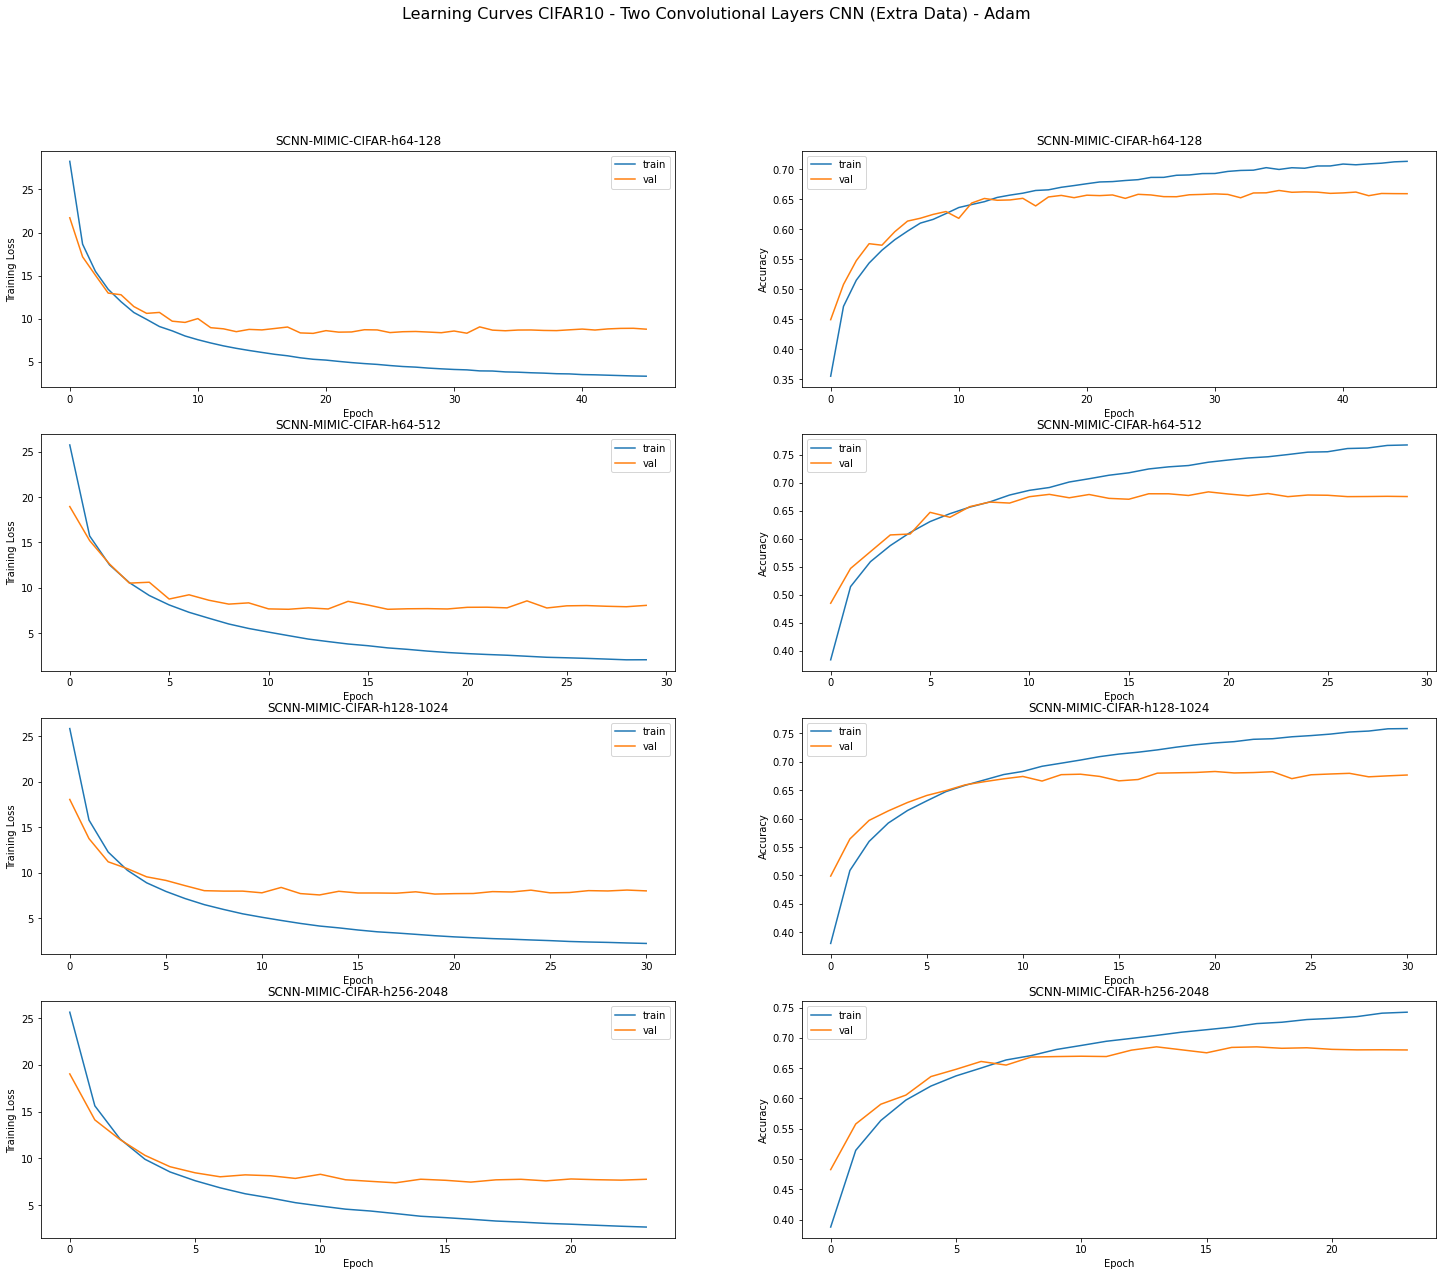

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves CIFAR10 - Two Convolutional Layers CNN (Extra Data) - Adam', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_128_1024, label='train');
plt.plot(loss_test_128_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h128-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_128_1024, label='train');
plt.plot(acc_test_128_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h128-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_256_2048, label='train');
plt.plot(loss_test_256_2048, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h256-2048')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_256_2048, label='train');
plt.plot(acc_test_256_2048, label='val');
plt.legend();
plt.title('SCNN-MIMIC-CIFAR-h256-2048')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

### Training for 2 Layers with Temperature in Teacher model

#### Adjust 2 Layers with Temperature in Teacher model

In [ ]:
from scipy.special import softmax
def get_temperature_predictions (svhn_model, name, x_train, x_test, T):

  # Get the hard logits from the model
  svhn_model = Model(svhn_model.input, svhn_model.get_layer('logit').output)
  
  train_logits_hard = svhn_model.predict(x_train)
  test_logits_hard = svhn_model.predict(x_test)

  # Devide with temperature
  train_logits_hard = train_logits_hard / T
  test_logits_hard = test_logits_hard / T

  # Pass it through softmax activation
  train_predictions = softmax(train_logits_hard, axis=1)
  test_predictions = softmax(test_logits_hard, axis=1)

  return train_predictions, test_predictions

#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn_extra_cifar.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn_extra_cifar.npy')

#### Training

In [ ]:
import shutil

# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

channels_to_test = [64, 64, 128, 256] 
channels_to_test2 = [128, 512, 1024, 2048] 

index_for_two = 0;

temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

for channel in channels_to_test:
  for t in temperatures:

    # Set name
    name = 'SCNN-CIFAR-h'+ str(index_for_two)
    svhn_model = get_CNN_model()
    svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_CIFAR.h5')

    train_predictions, test_predictions = get_temperature_predictions (svhn_model, name, x_train_cnn_extra, x_test_cnn_extra, t)
        
    svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
    svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #Save trained SNN model
    svhn_model = train_scnn(svhn_model, x_train_cnn_extra, train_predictions, x_test_cnn_extra, test_predictions)

    # Learning Curves Data
    loss_train_cnn=svhn_model.history.history['loss']
    loss_val_cnn=svhn_model.history.history['val_loss']
    acc_train_cnn=svhn_model.history.history['accuracy']
    acc_val_cnn=svhn_model.history.history['val_accuracy']

    print ("")
    print (loss_train_cnn)
    print ("")
    print (loss_val_cnn)
    print ("")
    print (acc_train_cnn)
    print ("")
    print (acc_val_cnn)

    name_to_store = 'SCNN_MIMIC_CIFAR_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+str('_')+str(t)+'.h5'
    svhn_model.save(name_to_store)
    print ('Model: '+name_to_store+' was saved')

    svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
    svhn_model = keras.models.load_model(name_to_store)

    score = 0;
    preds = svhn_model.predict(x_acc_test_cnn)
    for i in range (len(x_acc_test_cnn)):
      if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
        score = score + 1

    score=score/10000.0
    print ("Test Accuracy: %.5f" % score)
    scores_2_layer.append(score)
    channels_number.append(channel)

    shutil.move("/content/"+name_to_store, "/content/drive/My Drive/"+name_to_store)

    print ('----------------------------')

  index_for_two = index_for_two + 1
  print ('##############################')

#### Results

##### Accuracy Results Lowering - Adam

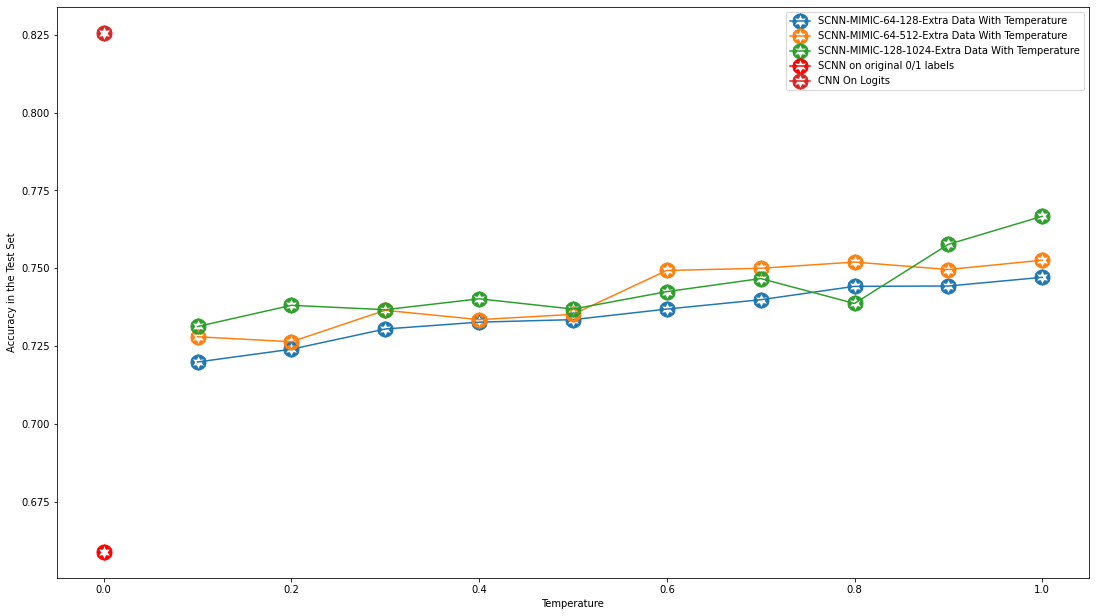

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.71990, 0.72400, 0.73050, 0.73270, 0.73350, 0.73690, 0.73990, 0.74420, 0.74430, 0.74710], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.72800, 0.72640, 0.73650, 0.73350, 0.73520, 0.74930, 0.75000, 0.75200, 0.74960, 0.75260], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.73130, 0.73810, 0.73670, 0.74020, 0.73690, 0.74250, 0.74670, 0.73870, 0.75770, 0.76670], label='SCNN-MIMIC-128-1024-Extra Data With Temperature', marker=cut_star, markersize=15)

plt.plot(0, 0.65890, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.82560, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Accuracy Results Raising - Adam

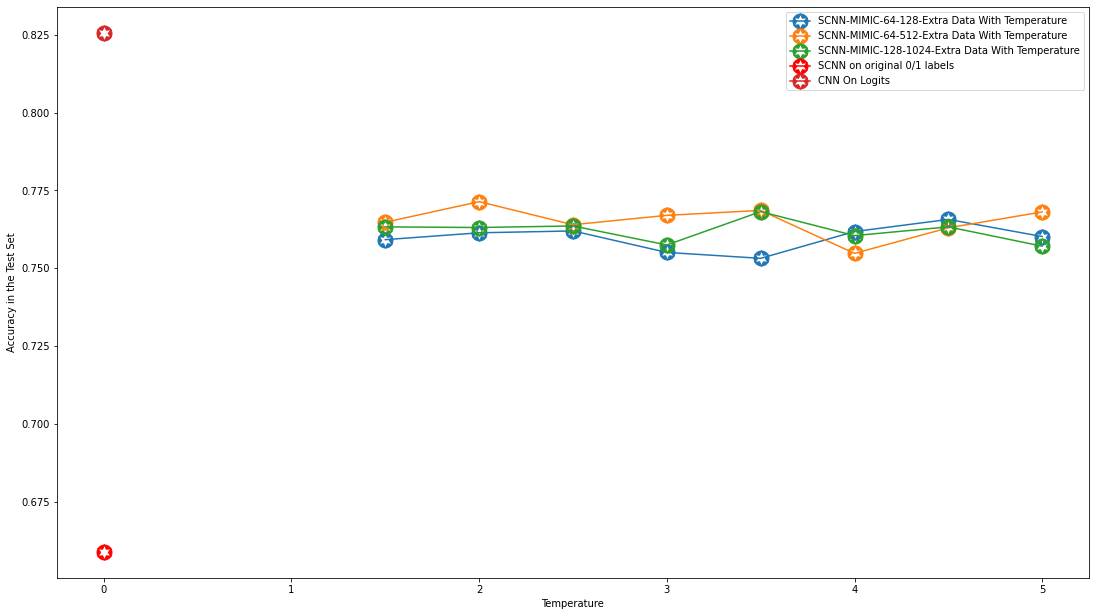

In [ ]:
import matplotlib.path as mpath
import numpy as np
import matplotlib.patches as patches

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.75920, 0.76140, 0.76200, 0.75510, 0.75320, 0.76180, 0.76570, 0.76020], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.76480, 0.77140, 0.76400, 0.76700, 0.76860, 0.75480, 0.76300, 0.76810], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.76330, 0.76310, 0.76360, 0.75750, 0.76820, 0.76050, 0.76330, 0.75710], label='SCNN-MIMIC-128-1024-Extra Data With Temperature', marker=cut_star, markersize=15)

plt.plot(0, 0.65890, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.82560, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Accuracy Results [0.1-5] - Adam

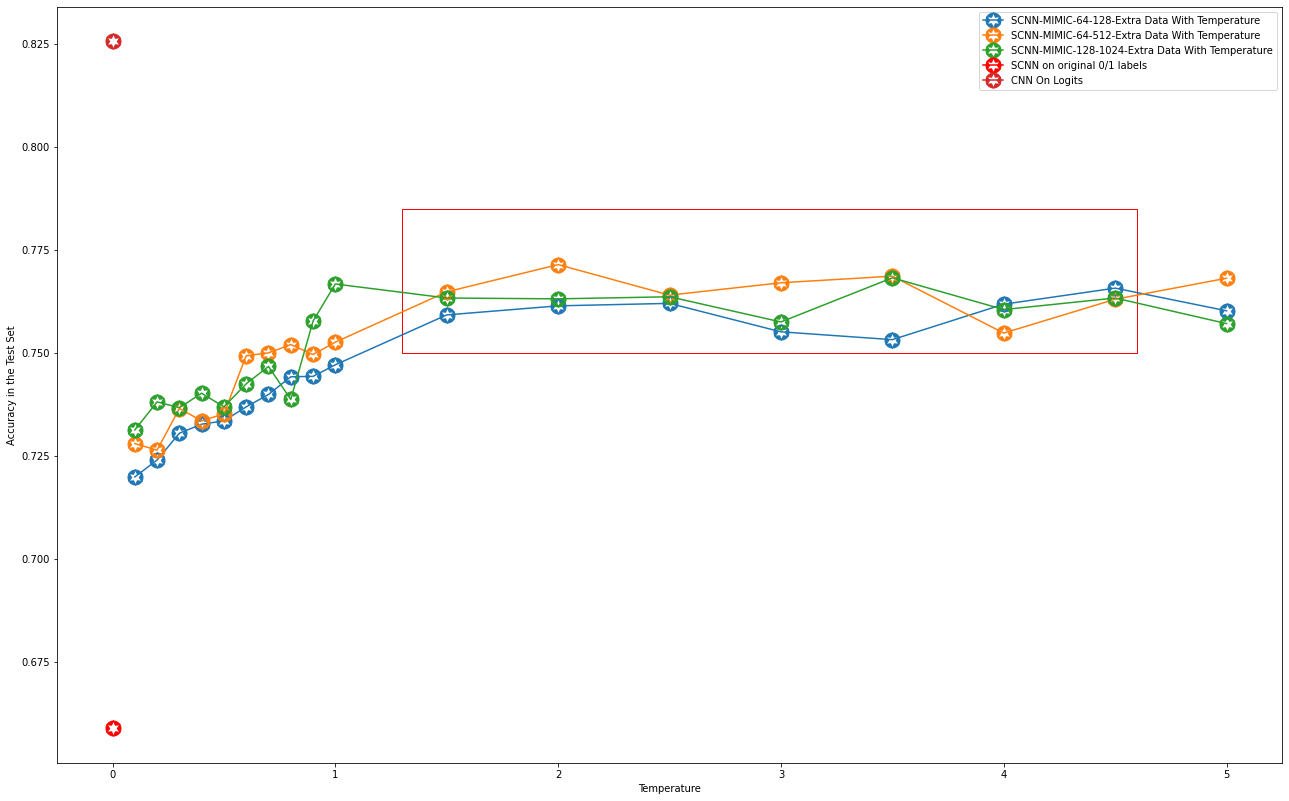

In [10]:
import matplotlib.path as mpath
import numpy as np
import matplotlib.patches as patches
rect = patches.Rectangle( (1.3, 0.75), 3.3, 0.035, linewidth=1, edgecolor='r', facecolor='none')


star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
ax = fig.add_axes([0,0,0.92,1])
ax.add_patch(rect)
fig.set_size_inches(18.5, 10.5)

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.71990, 0.72400, 0.73050, 0.73270, 0.73350, 0.73690, 0.73990, 0.74420, 0.74430, 0.74710,0.75920, 0.76140, 0.76200, 0.75510, 0.75320, 0.76180, 0.76570, 0.76020], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.72800, 0.72640, 0.73650, 0.73350, 0.73520, 0.74930, 0.75000, 0.75200, 0.74960, 0.75260,0.76480, 0.77140, 0.76400, 0.76700, 0.76860, 0.75480, 0.76300, 0.76810], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.73130, 0.73810, 0.73670, 0.74020, 0.73690, 0.74250, 0.74670, 0.73870, 0.75770, 0.76670,0.76330, 0.76310, 0.76360, 0.75750, 0.76820, 0.76050, 0.76330, 0.75710], label='SCNN-MIMIC-128-1024-Extra Data With Temperature', marker=cut_star, markersize=15)

plt.plot(0, 0.65890, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.82560, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

## Filter Pruning

In [ ]:
# Load the model
svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=512)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_CIFAR_h64_512_2.0.h5')
svhn_model.summary()

In [ ]:
# Evaluate CNN Test Set
svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=512)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_CIFAR_h64_512_2.0.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate CNN Validation Set
svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=512)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_CIFAR_h64_512_2.0.h5')
score, acc = svhn_model.evaluate(x_test_cnn, y_test, batch_size=128)
print ("Test Validation: %.5f" % acc)

In [ ]:
import matplotlib.pyplot as plt

svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=512)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_CIFAR_h64_512_2.0.h5')

w1 = svhn_model.layers[0].get_weights()[0]
w2 = svhn_model.layers[2].get_weights()[0]

conv_layers_weights = [w1,w2]

lists_weights = []

for i in range(len(conv_layers_weights)):
  weight = conv_layers_weights[i]
  weights_dict = {}
  num_filters = len(weight[0,0,0,:])

  for j in range(num_filters):
    w_s = np.sum(abs(weight[:,:,:,j]))
    filt = 'filt_{}'.format(j)
    weights_dict[filt] = w_s

  weights_dict_sort = sorted(weights_dict.items(), key=lambda kv: kv[1])
  print ('L1 norm conv layer {} \n'.format(i+1), weights_dict_sort)

  lists_weights.append(weights_dict_sort)

  weights_value = []
  for elem in weights_dict_sort:
    weights_value.append(elem[1])

  xc = range (num_filters)

  plt.figure(i+1, figsize=(7,5))
  plt.plot(xc, weights_value)
  plt.xlabel('filter_num')
  plt.ylabel('l1 norm')
  plt.title('conv layer {}'.format(i+1))
  plt.grid(True)

In [ ]:
!pip install kerassurgeon

In [ ]:
list_of_channels_to_remove_l2=[]

for item in lists_weights[1]:
  if (item[1] <= 20):
    new = item[0].split("_")
    list_of_channels_to_remove_l2.append(int(new[1]))

print (list_of_channels_to_remove_l2)

list_of_channels_to_remove_l1=[]

for item in lists_weights[0]:
  if (item[1] <= 1.4):
    new = item[0].split("_")
    list_of_channels_to_remove_l1.append(int(new[1]))

print (list_of_channels_to_remove_l1)

In [ ]:
from kerassurgeon import identify
from kerassurgeon.operations import delete_channels, delete_layer

svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=512)
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN_MIMIC_CIFAR_h64_512_2.0.h5')

layer_1 = svhn_model.layers[0]
layer_2 = svhn_model.layers[2]

model_new = delete_channels(svhn_model, layer_2, list_of_channels_to_remove_l2)
model_new = delete_channels(model_new, layer_1, list_of_channels_to_remove_l1)

model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_new.save('SCNN_MIMIC_CIFAR_h64_512_2.0_new')

model_new.summary()

score, acc = model_new.evaluate(x_test_cnn, y_test, batch_size=128)
print ("Test Validation: %.5f" % acc)

In [ ]:
score, acc = model_new.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Validation: %.5f" % acc)